In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML, SVG
from db import Result
import papermill as pm
import scrapbook as sb
import os
import seaborn
import pandas
import matplotlib.pyplot as plt
from collections import defaultdict 
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.metrics import cohen_kappa_score
from evaluate import calculate_confusion_matrix_stats_predictions, calculate_roc_curve, roc_auc_score
from scipy.stats import binom_test, fisher_exact, chi2_contingency
from tabulate import tabulate
from calculate_features import all_features
from config import config
from data_gen import data
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
plt.rcParams['svg.fonttype'] = 'none'

In [31]:
SKIP = False
UUIDS = [
    #"8af9ab00-4d86-41ce-8a48-659af724d622", #t2
    #"c26d1754-30e7-482d-af0c-93834c484085", #t1c
    #"bb10c0e7-e7dc-418b-8b59-d9ac94790031", #t1-specific
    #"43a64e79-3c40-442f-b318-7ca9e0c4a2be", #t1-sensitive
    #"d786bcef-7a8a-4bcb-b80a-b2125d18fbfa", #t2-specific
    #"dcae56f4-f8fb-4d8c-856e-984937195aa1", #t2-sensitive
    
    #Actual models
    #"a266e5a5-4baf-421a-a412-11490d130b38", # 7, prox/dist leg split
    #"82dc825c-9b8a-4e07-aa87-eca1a7ef2a59", # features, original
    #"f4340657-422b-48f7-99ac-1598608c10bf", # features, all new features
    #"dc2fc811-4fcc-49f2-92ad-4301fa064e27", # 9 features with original set
    #"8057ab69-a4f6-4583-840c-b1eb195ea7aa", #10 features, new set
    #"dcae56f4-f8fb-4d8c-856e-984937195aa1", #optimal T2
    #"d8563137-6958-41e4-9d35-d9a9be745887", #"f683af1e-e68c-4180-beef-c9c040c4d63f", # t2, original
    #"cd40b79a-7071-4beb-97dd-248b52f2687e", #optimal t1
    #"69d65638-156f-4a73-bf6c-b6658294af4a", # t1, original
    
    #For real this time
    "dcae56f4-f8fb-4d8c-856e-984937195aa1", #t2 sensitive
    "d786bcef-7a8a-4bcb-b80a-b2125d18fbfa", #t2 specific
    "43a64e79-3c40-442f-b318-7ca9e0c4a2be", #t1 sensistive
    "bb10c0e7-e7dc-418b-8b59-d9ac94790031", #t1 specific
    "8057ab69-a4f6-4583-840c-b1eb195ea7aa", #clinical
]
SELECTIONS = {
}
TSNE_PERPLEXITY = {
}
MODALITY = {
    #For real this time
    "dcae56f4-f8fb-4d8c-856e-984937195aa1": "t2-sn", #t2 sensitive
    "d786bcef-7a8a-4bcb-b80a-b2125d18fbfa": "t2-sp", #t2 specific
    "43a64e79-3c40-442f-b318-7ca9e0c4a2be": "t1-sn", #t1 sensistive
    "bb10c0e7-e7dc-418b-8b59-d9ac94790031": "t1-sp", #t1 specific
    "8057ab69-a4f6-4583-840c-b1eb195ea7aa": "features", #clinical
    #"8af9ab00-4d86-41ce-8a48-659af724d622": "t2", #t2
    #"c26d1754-30e7-482d-af0c-93834c484085": "t1c", #t1c
    #"bb10c0e7-e7dc-418b-8b59-d9ac94790031": "t1", #t1-specific
    #"43a64e79-3c40-442f-b318-7ca9e0c4a2be": "t1", #t1-sensitive
    #"d786bcef-7a8a-4bcb-b80a-b2125d18fbfa": "t2", #t2-specific
    #"dcae56f4-f8fb-4d8c-856e-984937195aa1": "t2", #t2-sensitive
    
    #Actual models
    #"a266e5a5-4baf-421a-a412-11490d130b38": "features",
    #"82dc825c-9b8a-4e07-aa87-eca1a7ef2a59": "features", # features, original
    #"f4340657-422b-48f7-99ac-1598608c10bf": "features", #features, all new features
    #"dc2fc811-4fcc-49f2-92ad-4301fa064e27": "features", # 9 features with original set
    #"8057ab69-a4f6-4583-840c-b1eb195ea7aa": "features", #features, 10 features
    #"dcae56f4-f8fb-4d8c-856e-984937195aa1": "t2",
    #"cd40b79a-7071-4beb-97dd-248b52f2687e": "t1",
    
    #"d8563137-6958-41e4-9d35-d9a9be745887": "t2", #"f683af1e-e68c-4180-beef-c9c040c4d63f", # t2 
    #"69d65638-156f-4a73-bf6c-b6658294af4a": "t1", # t1
}
FEATURES_MODELS = [
    #"a266e5a5-4baf-421a-a412-11490d130b38",
    #"dc2fc811-4fcc-49f2-92ad-4301fa064e27", # 9 features with original set
    "8057ab69-a4f6-4583-840c-b1eb195ea7aa"
    #"f4340657-422b-48f7-99ac-1598608c10bf"
    #"82dc825c-9b8a-4e07-aa87-eca1a7ef2a59"
]

In [34]:
import math
def adjusted_wald(p, n, z=1.96):
    p_adj = (n * p + (z**2)/2)/(n+z**2)
    n_adj = n + z**2
    span = z * math.sqrt(p_adj*(1-p_adj)/n_adj)
    return max(0, p_adj - span), min(p_adj + span, 1.0)

In [35]:
def execute_notebook(uuid, selections=None, tsne_perplexity=5, input_form="none", description=""): 
    name = "notebooks/evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid)
    if not SKIP and not os.path.exists(name):
        if uuid not in FEATURES_MODELS:
            pm.execute_notebook(
                "evaluate-specific-model.ipynb",
                "notebooks/evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid),
                parameters = dict(
                    UUID=uuid,
                    SELECTIONS=repr(selections),
                    TSNE_PERPLEXITY=tsne_perplexity,
                ))
        else:
            pm.execute_notebook(
                "evaluate-specific-feature-model.ipynb",
                "notebooks/evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid),
                parameters = dict(
                    UUID=uuid
                ))
    return name

In [36]:
completed_notebooks = list()
modality_by_notebook = dict()

In [37]:
for uuid in UUIDS: 
    print(uuid)
    result = Result.query.filter(Result.uuid == uuid).first()
    name = execute_notebook(uuid, SELECTIONS.get(uuid), TSNE_PERPLEXITY.get(uuid), result.input_form, result.description)
    completed_notebooks.append(name)
    modality_by_notebook[name] = MODALITY[uuid]
    print("done")

dcae56f4-f8fb-4d8c-856e-984937195aa1
done
d786bcef-7a8a-4bcb-b80a-b2125d18fbfa
done
43a64e79-3c40-442f-b318-7ca9e0c4a2be
done
bb10c0e7-e7dc-418b-8b59-d9ac94790031
done
8057ab69-a4f6-4583-840c-b1eb195ea7aa
done


In [38]:
modality_by_notebook

{'notebooks/evaluate-t2_final_run_200-t2-dcae56f4-f8fb-4d8c-856e-984937195aa1.ipynb': 't2-sn',
 'notebooks/evaluate-t2_final_run_200-t2-d786bcef-7a8a-4bcb-b80a-b2125d18fbfa.ipynb': 't2-sp',
 'notebooks/evaluate-t1_final_200-t1-43a64e79-3c40-442f-b318-7ca9e0c4a2be.ipynb': 't1-sn',
 'notebooks/evaluate-t1_final_200-t1-bb10c0e7-e7dc-418b-8b59-d9ac94790031.ipynb': 't1-sp',
 'notebooks/evaluate-RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=10)-features-8057ab69-a4f6-4583-840c-b1eb195ea7aa.ipynb': 'features'}

In [39]:
name = "notebooks/evaluate-ensemble-{}.ipynb".format("-".join(UUIDS))
if not SKIP and not os.path.exists(name): 
    pm.execute_notebook(
        "evaluate-ensemble.ipynb",
        "notebooks/evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)),
        parameters = dict(
            MODELS=UUIDS,
            SCORE="accuracy",
        ),
    )
completed_notebooks.append("notebooks/evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)))

Executing:   0%|          | 0/55 [00:00<?, ?cell/s]

In [40]:
modality_by_notebook["notebooks/evaluate-ensemble-{}.ipynb".format("-".join(UUIDS))] = "ensemble"

In [41]:
def get_notebook_output(notebook, name): 
    return notebook[name]
    #return (notebook.scrap_dataframe[notebook.scrap_dataframe.name==name].value.tolist())[0]

In [42]:
train = dict()
validation = dict()
test = dict()
external = dict()
test_1 = dict()
test_2 = dict()
for notebook in completed_notebooks:
    nb = sb.read_notebook(notebook)
    nb = nb.scraps.data_dict
    train["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "train_labels")
    train["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "train_predictions")
    train["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "train_probabilities")
    validation["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "validation_labels")
    validation["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "validation_predictions")
    validation["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "validation_probabilities")
    test["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test_labels")
    test["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test_predictions")
    test["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test_probabilities")
    external["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "external_labels")
    external["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "external_predictions")
    external["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "external_probabilities")
    #test_1["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test-1_labels")
    #test_1["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test-1_predictions")
    #test_1["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test-1_probabilities")
    #test_2["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test-2_labels")
    #test_2["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test-2_predictions")
    #test_2["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test-2_probabilities")                                                     

In [43]:
print(len(train["ensemble-predictions"]))
print(len(validation["ensemble-predictions"]))
print(len(test["ensemble-predictions"]))

678
191
93


In [44]:
completed_notebooks

['notebooks/evaluate-t2_final_run_200-t2-dcae56f4-f8fb-4d8c-856e-984937195aa1.ipynb',
 'notebooks/evaluate-t2_final_run_200-t2-d786bcef-7a8a-4bcb-b80a-b2125d18fbfa.ipynb',
 'notebooks/evaluate-t1_final_200-t1-43a64e79-3c40-442f-b318-7ca9e0c4a2be.ipynb',
 'notebooks/evaluate-t1_final_200-t1-bb10c0e7-e7dc-418b-8b59-d9ac94790031.ipynb',
 'notebooks/evaluate-RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=10)-features-8057ab69-a4f6-4583-840c-b1eb195ea7aa.ipynb',
 'notebooks/evaluate-ensemble-dcae56f4-f8fb-4d8c-856e-984937195aa1-d786bcef-7a8a-4bcb-b80a-b2125d18fbfa-43a64e79-3c40-442f-b318-7ca9e0c4a2be-bb10c0e7-e7dc-418b-8b59-d9ac94790031-8057ab69-a4f6-4583-840c-b1eb195ea7aa.ipynb']

In [45]:
import uuid
result = Result.query.filter(Result.uuid == UUIDS[0]).first()
print(result.uuid)
print(result.split_seed)
train_set, validation_set, test_set, external_set = data(seed=uuid.UUID(result.split_seed), label_form=result.label_form, input_form=result.input_form, train_shuffle=False, test_shuffle=False, validation_shuffle=False, train_augment=False, validation_augment=False, test_augment=False)

  0%|          | 0/678 [00:00<?, ?it/s]

dcae56f4-f8fb-4d8c-856e-984937195aa1
84a64c17-fe3e-440c-aaaf-e1bd5b02576f
                outcome_pos  outcome_neg  outcome_3   age  sex  \
patientID                                                        
bone-brown-1              0            0          0  52.0    1   
bone-brown-10             0            0          0  52.0    0   
bone-brown-100            1            1          2  22.0    1   
bone-brown-101            0            0          0  88.0    0   
bone-brown-102            0            0          0  56.0    1   
...                     ...          ...        ...   ...  ...   
bone-penn-650             1            1          2  20.0    1   
bone-penn-651             0            0          0  16.0    1   
bone-penn-652             1            1          2   8.0    0   
bone-penn-653             1            1          2  16.0    1   
bone-penn-654             1            1          2   3.0    1   

                                                         location  

  0%|          | 2/678 [00:00<02:20,  4.82it/s]

I'm doing the thing.
bone-brown-101
I'm doing the thing.


  0%|          | 3/678 [00:00<02:55,  3.84it/s]

I'm doing the thing.
bone-brown-103
I'm doing the thing.


  1%|          | 4/678 [00:01<03:18,  3.39it/s]

I'm doing the thing.
bone-brown-106
I'm doing the thing.


  1%|          | 6/678 [00:02<06:00,  1.87it/s]

I'm doing the thing.
bone-brown-107
I'm doing the thing.
I'm doing the thing.
bone-brown-11
I'm doing the thing.


  1%|          | 7/678 [00:03<05:02,  2.22it/s]

I'm doing the thing.
bone-brown-110
I'm doing the thing.
I'm doing the thing.
bone-brown-112
I'm doing the thing.


  1%|▏         | 9/678 [00:03<03:40,  3.03it/s]

I'm doing the thing.
bone-brown-113
I'm doing the thing.


  1%|▏         | 10/678 [00:03<03:42,  3.00it/s]

I'm doing the thing.
bone-brown-114
I'm doing the thing.


  2%|▏         | 11/678 [00:04<03:36,  3.08it/s]

I'm doing the thing.
bone-brown-115
I'm doing the thing.


  2%|▏         | 12/678 [00:04<03:55,  2.83it/s]

I'm doing the thing.
bone-brown-116
I'm doing the thing.


  2%|▏         | 13/678 [00:04<03:46,  2.94it/s]

I'm doing the thing.
bone-brown-117
I'm doing the thing.


  2%|▏         | 15/678 [00:05<04:02,  2.73it/s]

I'm doing the thing.
bone-brown-120
I'm doing the thing.
I'm doing the thing.
bone-brown-121
I'm doing the thing.


  3%|▎         | 17/678 [00:05<02:36,  4.21it/s]

I'm doing the thing.
bone-brown-123
I'm doing the thing.
I'm doing the thing.
bone-brown-124
I'm doing the thing.


  3%|▎         | 18/678 [00:06<03:21,  3.27it/s]

I'm doing the thing.
bone-brown-125
I'm doing the thing.


  3%|▎         | 20/678 [00:06<02:57,  3.71it/s]

I'm doing the thing.
bone-brown-13
I'm doing the thing.
I'm doing the thing.
bone-brown-14
I'm doing the thing.
I'm doing the thing.
bone-brown-15
I'm doing the thing.


  3%|▎         | 22/678 [00:07<02:26,  4.47it/s]

I'm doing the thing.
bone-brown-17
I'm doing the thing.


  3%|▎         | 23/678 [00:07<03:03,  3.56it/s]

I'm doing the thing.
bone-brown-19
I'm doing the thing.


  4%|▎         | 24/678 [00:08<03:12,  3.39it/s]

I'm doing the thing.
bone-brown-2
I'm doing the thing.


  4%|▎         | 25/678 [00:08<03:22,  3.23it/s]

I'm doing the thing.
bone-brown-20
I'm doing the thing.


  4%|▍         | 26/678 [00:08<03:24,  3.19it/s]

I'm doing the thing.
bone-brown-21
I'm doing the thing.


  4%|▍         | 27/678 [00:09<04:16,  2.54it/s]

I'm doing the thing.
bone-brown-22
I'm doing the thing.
I'm doing the thing.
bone-brown-23
I'm doing the thing.


  4%|▍         | 29/678 [00:09<03:12,  3.37it/s]

I'm doing the thing.
bone-brown-24
I'm doing the thing.
I'm doing the thing.
bone-brown-25
I'm doing the thing.


  5%|▍         | 33/678 [00:10<02:20,  4.60it/s]

I'm doing the thing.
bone-brown-27
I'm doing the thing.
I'm doing the thing.
bone-brown-29
I'm doing the thing.
I'm doing the thing.
bone-brown-3
I'm doing the thing.


  5%|▌         | 34/678 [00:10<02:30,  4.28it/s]

I'm doing the thing.
bone-brown-31
I'm doing the thing.


  5%|▌         | 35/678 [00:10<02:30,  4.26it/s]

I'm doing the thing.
bone-brown-32
I'm doing the thing.


  5%|▌         | 36/678 [00:11<02:31,  4.24it/s]

I'm doing the thing.
bone-brown-34
I'm doing the thing.


  5%|▌         | 37/678 [00:11<03:01,  3.54it/s]

I'm doing the thing.
bone-brown-35
I'm doing the thing.


  6%|▌         | 38/678 [00:11<03:07,  3.42it/s]

I'm doing the thing.
bone-brown-37
I'm doing the thing.


  6%|▌         | 40/678 [00:12<02:38,  4.03it/s]

I'm doing the thing.
bone-brown-38
I'm doing the thing.
I'm doing the thing.
bone-brown-39
I'm doing the thing.


  6%|▌         | 41/678 [00:12<02:43,  3.89it/s]

I'm doing the thing.
bone-brown-41
I'm doing the thing.


  6%|▌         | 42/678 [00:13<03:10,  3.34it/s]

I'm doing the thing.
bone-brown-42
I'm doing the thing.


  6%|▋         | 43/678 [00:14<05:38,  1.87it/s]

I'm doing the thing.
bone-brown-44
I'm doing the thing.


  6%|▋         | 44/678 [00:15<07:04,  1.49it/s]

I'm doing the thing.
bone-brown-46
I'm doing the thing.
I'm doing the thing.
bone-brown-50
I'm doing the thing.


  7%|▋         | 46/678 [00:15<05:30,  1.91it/s]

I'm doing the thing.
bone-brown-51
I'm doing the thing.


  7%|▋         | 47/678 [00:16<05:05,  2.07it/s]

I'm doing the thing.
bone-brown-52
I'm doing the thing.


  7%|▋         | 48/678 [00:16<04:23,  2.39it/s]

I'm doing the thing.
bone-brown-53
I'm doing the thing.
I'm doing the thing.
bone-brown-54
I'm doing the thing.


  7%|▋         | 50/678 [00:16<03:30,  2.99it/s]

I'm doing the thing.
bone-brown-56
I'm doing the thing.


  8%|▊         | 52/678 [00:17<02:59,  3.49it/s]

I'm doing the thing.
bone-brown-58
I'm doing the thing.
I'm doing the thing.
bone-brown-59
I'm doing the thing.


  8%|▊         | 53/678 [00:17<03:51,  2.70it/s]

I'm doing the thing.
bone-brown-6
I'm doing the thing.


  8%|▊         | 54/678 [00:19<05:49,  1.79it/s]

I'm doing the thing.
bone-brown-63
I'm doing the thing.


  8%|▊         | 56/678 [00:19<04:19,  2.40it/s]

I'm doing the thing.
bone-brown-64
I'm doing the thing.
I'm doing the thing.
bone-brown-65
I'm doing the thing.


  9%|▊         | 59/678 [00:20<02:41,  3.84it/s]

I'm doing the thing.
bone-brown-68
I'm doing the thing.
I'm doing the thing.
bone-brown-70
I'm doing the thing.
I'm doing the thing.
bone-brown-72
I'm doing the thing.


  9%|▉         | 60/678 [00:20<02:58,  3.46it/s]

I'm doing the thing.
bone-brown-73
I'm doing the thing.


  9%|▉         | 62/678 [00:21<02:39,  3.86it/s]

I'm doing the thing.
bone-brown-74
I'm doing the thing.
I'm doing the thing.
bone-brown-75
I'm doing the thing.


  9%|▉         | 63/678 [00:21<02:49,  3.63it/s]

I'm doing the thing.
bone-brown-76
I'm doing the thing.


  9%|▉         | 64/678 [00:21<02:40,  3.83it/s]

I'm doing the thing.
bone-brown-77
I'm doing the thing.


 10%|▉         | 66/678 [00:22<02:28,  4.12it/s]

I'm doing the thing.
bone-brown-78
I'm doing the thing.
I'm doing the thing.
bone-brown-8
I'm doing the thing.


 10%|▉         | 67/678 [00:22<02:39,  3.84it/s]

I'm doing the thing.
bone-brown-81
I'm doing the thing.
I'm doing the thing.
bone-brown-83
I'm doing the thing.


 10%|█         | 69/678 [00:22<02:26,  4.15it/s]

I'm doing the thing.
bone-brown-84
I'm doing the thing.


 10%|█         | 70/678 [00:24<06:14,  1.62it/s]

I'm doing the thing.
bone-brown-85
I'm doing the thing.


 10%|█         | 71/678 [00:25<06:13,  1.63it/s]

I'm doing the thing.
bone-brown-86
I'm doing the thing.


 11%|█         | 72/678 [00:25<05:26,  1.86it/s]

I'm doing the thing.
bone-brown-88
I'm doing the thing.


 11%|█         | 73/678 [00:25<04:46,  2.12it/s]

I'm doing the thing.
bone-brown-89
I'm doing the thing.


 11%|█         | 75/678 [00:26<03:17,  3.05it/s]

I'm doing the thing.
bone-brown-91
I'm doing the thing.
I'm doing the thing.
bone-brown-92
I'm doing the thing.


 11%|█         | 76/678 [00:26<03:35,  2.80it/s]

I'm doing the thing.
bone-brown-94
I'm doing the thing.


 11%|█▏        | 77/678 [00:26<03:07,  3.21it/s]

I'm doing the thing.
bone-brown-95
I'm doing the thing.


 12%|█▏        | 78/678 [00:27<03:10,  3.15it/s]

I'm doing the thing.
bone-brown-96
I'm doing the thing.
I'm doing the thing.
bone-brown-97
I'm doing the thing.


 12%|█▏        | 80/678 [00:27<02:21,  4.22it/s]

I'm doing the thing.
bone-brown-99
I'm doing the thing.


 12%|█▏        | 82/678 [00:28<02:37,  3.79it/s]

I'm doing the thing.
bone-china-002
I'm doing the thing.
I'm doing the thing.
bone-china-004
I'm doing the thing.
I'm doing the thing.
bone-china-005
I'm doing the thing.


 13%|█▎        | 86/678 [00:28<01:24,  7.02it/s]

I'm doing the thing.
bone-china-006
I'm doing the thing.
I'm doing the thing.
bone-china-008
I'm doing the thing.
I'm doing the thing.
bone-china-009
I'm doing the thing.


 13%|█▎        | 88/678 [00:28<01:11,  8.31it/s]

I'm doing the thing.
bone-china-010
I'm doing the thing.
I'm doing the thing.
bone-china-014
I'm doing the thing.
I'm doing the thing.
bone-china-015
I'm doing the thing.


 14%|█▎        | 93/678 [00:28<00:48, 12.15it/s]

I'm doing the thing.
bone-china-019
I'm doing the thing.
I'm doing the thing.
bone-china-020
I'm doing the thing.
I'm doing the thing.
bone-china-021
I'm doing the thing.
I'm doing the thing.
bone-china-022
I'm doing the thing.
I'm doing the thing.
bone-china-023
I'm doing the thing.


 14%|█▍        | 97/678 [00:29<00:45, 12.75it/s]

I'm doing the thing.
bone-china-027
I'm doing the thing.
I'm doing the thing.
bone-china-028
I'm doing the thing.
I'm doing the thing.
bone-china-029
I'm doing the thing.
I'm doing the thing.
bone-china-031
I'm doing the thing.


 15%|█▍        | 101/678 [00:29<00:43, 13.39it/s]

I'm doing the thing.
bone-china-033
I'm doing the thing.
I'm doing the thing.
bone-china-035
I'm doing the thing.
I'm doing the thing.
bone-china-037
I'm doing the thing.


 15%|█▌        | 103/678 [00:29<00:45, 12.60it/s]

I'm doing the thing.
bone-china-038
I'm doing the thing.
I'm doing the thing.
bone-china-039
I'm doing the thing.
I'm doing the thing.
bone-china-041
I'm doing the thing.


 16%|█▌        | 107/678 [00:29<00:46, 12.21it/s]

I'm doing the thing.
bone-china-044
I'm doing the thing.
I'm doing the thing.
bone-china-045
I'm doing the thing.
I'm doing the thing.
bone-china-046
I'm doing the thing.


 16%|█▋        | 111/678 [00:30<00:43, 12.90it/s]

I'm doing the thing.
bone-china-047
I'm doing the thing.
I'm doing the thing.
bone-china-050
I'm doing the thing.
I'm doing the thing.
bone-china-051
I'm doing the thing.
I'm doing the thing.
bone-china-052
I'm doing the thing.


 17%|█▋        | 114/678 [00:30<00:37, 14.99it/s]

I'm doing the thing.
bone-china-053
I'm doing the thing.
I'm doing the thing.
bone-china-055
I'm doing the thing.
I'm doing the thing.
bone-china-056
I'm doing the thing.
I'm doing the thing.
bone-china-058
I'm doing the thing.


 17%|█▋        | 118/678 [00:30<00:51, 10.78it/s]

I'm doing the thing.
bone-china-059
I'm doing the thing.
I'm doing the thing.
bone-china-060
I'm doing the thing.
I'm doing the thing.
bone-china-061
I'm doing the thing.
I'm doing the thing.
bone-china-062
I'm doing the thing.


 18%|█▊        | 122/678 [00:31<00:49, 11.33it/s]

I'm doing the thing.
bone-china-065
I'm doing the thing.
I'm doing the thing.
bone-china-066
I'm doing the thing.
I'm doing the thing.
bone-china-067
I'm doing the thing.


 18%|█▊        | 124/678 [00:31<00:46, 11.88it/s]

I'm doing the thing.
bone-china-068
I'm doing the thing.
I'm doing the thing.
bone-china-069
I'm doing the thing.
I'm doing the thing.
bone-china-070
I'm doing the thing.


 19%|█▉        | 128/678 [00:31<00:42, 13.07it/s]

I'm doing the thing.
bone-china-071
I'm doing the thing.
I'm doing the thing.
bone-china-072
I'm doing the thing.
I'm doing the thing.
bone-china-074
I'm doing the thing.


 19%|█▉        | 130/678 [00:31<00:44, 12.30it/s]

I'm doing the thing.
bone-china-075
I'm doing the thing.
I'm doing the thing.
bone-china-076
I'm doing the thing.


 19%|█▉        | 132/678 [00:32<00:59,  9.14it/s]

I'm doing the thing.
bone-china-079
I'm doing the thing.
I'm doing the thing.
bone-china-080
I'm doing the thing.


 20%|█▉        | 134/678 [00:32<00:56,  9.69it/s]

I'm doing the thing.
bone-china-081
I'm doing the thing.
I'm doing the thing.
bone-china-083
I'm doing the thing.
I'm doing the thing.
bone-china-084
I'm doing the thing.


 20%|██        | 138/678 [00:32<00:55,  9.76it/s]

I'm doing the thing.
bone-china-085
I'm doing the thing.
I'm doing the thing.
bone-china-086
I'm doing the thing.
I'm doing the thing.
bone-china-087
I'm doing the thing.


 21%|██        | 140/678 [00:33<00:59,  9.05it/s]

I'm doing the thing.
bone-china-088
I'm doing the thing.
I'm doing the thing.
bone-china-089
I'm doing the thing.


 21%|██        | 142/678 [00:33<00:52, 10.26it/s]

I'm doing the thing.
bone-china-090
I'm doing the thing.
I'm doing the thing.
bone-china-092
I'm doing the thing.
I'm doing the thing.
bone-china-093
I'm doing the thing.


 22%|██▏       | 146/678 [00:33<00:45, 11.80it/s]

I'm doing the thing.
bone-china-099
I'm doing the thing.
I'm doing the thing.
bone-china-100
I'm doing the thing.
I'm doing the thing.
bone-china-101
I'm doing the thing.


 22%|██▏       | 148/678 [00:33<00:43, 12.32it/s]

I'm doing the thing.
bone-china-103
I'm doing the thing.
I'm doing the thing.
bone-china-104
I'm doing the thing.


 22%|██▏       | 150/678 [00:33<00:49, 10.62it/s]

I'm doing the thing.
bone-china-105
I'm doing the thing.
I'm doing the thing.
bone-china-107
I'm doing the thing.


 22%|██▏       | 152/678 [00:34<00:46, 11.42it/s]

I'm doing the thing.
bone-china-109
I'm doing the thing.
I'm doing the thing.
bone-china-110
I'm doing the thing.
I'm doing the thing.
bone-china-113
I'm doing the thing.


 23%|██▎       | 156/678 [00:34<00:44, 11.64it/s]

I'm doing the thing.
bone-china-114
I'm doing the thing.
I'm doing the thing.
bone-china-117
I'm doing the thing.
I'm doing the thing.
bone-china-118
I'm doing the thing.


 23%|██▎       | 158/678 [00:34<00:49, 10.60it/s]

I'm doing the thing.
bone-china-121
I'm doing the thing.
I'm doing the thing.
bone-china-122
I'm doing the thing.


 24%|██▎       | 160/678 [00:34<00:50, 10.19it/s]

I'm doing the thing.
bone-china-123
I'm doing the thing.
I'm doing the thing.
bone-china-124
I'm doing the thing.


 24%|██▍       | 162/678 [00:35<00:48, 10.66it/s]

I'm doing the thing.
bone-china-125
I'm doing the thing.
I'm doing the thing.
bone-china-126
I'm doing the thing.
I'm doing the thing.
bone-china-127
I'm doing the thing.


 24%|██▍       | 166/678 [00:35<00:48, 10.56it/s]

I'm doing the thing.
bone-china-131
I'm doing the thing.
I'm doing the thing.
bone-china-132
I'm doing the thing.
I'm doing the thing.
bone-china-133
I'm doing the thing.


 25%|██▍       | 168/678 [00:35<00:51,  9.87it/s]

I'm doing the thing.
bone-china-134
I'm doing the thing.
I'm doing the thing.
bone-china-135
I'm doing the thing.


 25%|██▌       | 170/678 [00:35<00:45, 11.29it/s]

I'm doing the thing.
bone-china-136
I'm doing the thing.
I'm doing the thing.
bone-china-138
I'm doing the thing.
I'm doing the thing.
bone-china-140
I'm doing the thing.


 25%|██▌       | 172/678 [00:36<00:47, 10.60it/s]

I'm doing the thing.
bone-china-143
I'm doing the thing.
I'm doing the thing.
bone-china-145
I'm doing the thing.


 26%|██▌       | 174/678 [00:36<00:54,  9.30it/s]

I'm doing the thing.
bone-china-146
I'm doing the thing.
I'm doing the thing.
bone-china-148
I'm doing the thing.


 26%|██▌       | 177/678 [00:36<00:54,  9.12it/s]

I'm doing the thing.
bone-china-149
I'm doing the thing.
I'm doing the thing.
bone-china-152
I'm doing the thing.
I'm doing the thing.
bone-china-153
I'm doing the thing.


 27%|██▋       | 181/678 [00:36<00:43, 11.47it/s]

I'm doing the thing.
bone-china-154
I'm doing the thing.
I'm doing the thing.
bone-china-158
I'm doing the thing.
I'm doing the thing.
bone-china-159
I'm doing the thing.


 27%|██▋       | 183/678 [00:37<00:47, 10.51it/s]

I'm doing the thing.
bone-china-160
I'm doing the thing.
I'm doing the thing.
bone-china-161
I'm doing the thing.
I'm doing the thing.
bone-china-164
I'm doing the thing.


 28%|██▊       | 187/678 [00:37<00:39, 12.34it/s]

I'm doing the thing.
bone-china-166
I'm doing the thing.
I'm doing the thing.
bone-china-167
I'm doing the thing.
I'm doing the thing.
bone-china-169
I'm doing the thing.


 28%|██▊       | 189/678 [00:37<00:39, 12.37it/s]

I'm doing the thing.
bone-china-170
I'm doing the thing.
I'm doing the thing.
bone-china-174
I'm doing the thing.


 28%|██▊       | 191/678 [00:37<00:46, 10.57it/s]

I'm doing the thing.
bone-china-175
I'm doing the thing.
I'm doing the thing.
bone-china-176
I'm doing the thing.


 28%|██▊       | 193/678 [00:38<00:45, 10.66it/s]

I'm doing the thing.
bone-china-177
I'm doing the thing.
I'm doing the thing.
bone-china-180
I'm doing the thing.
I'm doing the thing.
bone-china-184
I'm doing the thing.


 29%|██▉       | 197/678 [00:38<00:38, 12.53it/s]

I'm doing the thing.
bone-china-186
I'm doing the thing.
I'm doing the thing.
bone-china-187
I'm doing the thing.
I'm doing the thing.
bone-china-189
I'm doing the thing.
I'm doing the thing.
bone-china-190
I'm doing the thing.


 30%|██▉       | 201/678 [00:38<00:35, 13.34it/s]

I'm doing the thing.
bone-china-192
I'm doing the thing.
I'm doing the thing.
bone-china-193
I'm doing the thing.
I'm doing the thing.
bone-china-194
I'm doing the thing.


 30%|██▉       | 203/678 [00:38<00:38, 12.24it/s]

I'm doing the thing.
bone-china-196
I'm doing the thing.
I'm doing the thing.
bone-china-198
I'm doing the thing.
I'm doing the thing.
bone-china-199
I'm doing the thing.


 31%|███       | 207/678 [00:39<00:38, 12.09it/s]

I'm doing the thing.
bone-china-203
I'm doing the thing.
I'm doing the thing.
bone-china-209
I'm doing the thing.
I'm doing the thing.
bone-china-212
I'm doing the thing.


 31%|███       | 209/678 [00:39<00:38, 12.33it/s]

I'm doing the thing.
bone-china-213
I'm doing the thing.
I'm doing the thing.
bone-china-215
I'm doing the thing.
I'm doing the thing.
bone-china-216
I'm doing the thing.


 31%|███▏      | 213/678 [00:39<00:37, 12.31it/s]

I'm doing the thing.
bone-china-217
I'm doing the thing.
I'm doing the thing.
bone-china-221
I'm doing the thing.
I'm doing the thing.
bone-china-222
I'm doing the thing.


 32%|███▏      | 215/678 [00:39<00:39, 11.70it/s]

I'm doing the thing.
bone-china-223
I'm doing the thing.
I'm doing the thing.
bone-china-225
I'm doing the thing.


 32%|███▏      | 217/678 [00:40<00:44, 10.26it/s]

I'm doing the thing.
bone-china-228
I'm doing the thing.
I'm doing the thing.
bone-china-231
I'm doing the thing.
I'm doing the thing.
bone-china-234
I'm doing the thing.


 32%|███▏      | 219/678 [00:40<00:47,  9.61it/s]

I'm doing the thing.
bone-china-242
I'm doing the thing.


 33%|███▎      | 221/678 [00:40<00:57,  7.93it/s]

I'm doing the thing.
bone-china-243
I'm doing the thing.
I'm doing the thing.
bone-hup-101
I'm doing the thing.


 33%|███▎      | 223/678 [00:40<01:06,  6.83it/s]

I'm doing the thing.
bone-hup-102
I'm doing the thing.
I'm doing the thing.
bone-hup-103
I'm doing the thing.
I'm doing the thing.
bone-hup-104
I'm doing the thing.


 33%|███▎      | 225/678 [00:41<00:58,  7.68it/s]

I'm doing the thing.
bone-hup-108
I'm doing the thing.
I'm doing the thing.
bone-hup-109
I'm doing the thing.


 33%|███▎      | 227/678 [00:41<01:09,  6.50it/s]

I'm doing the thing.
bone-hup-111
I'm doing the thing.


 34%|███▎      | 228/678 [00:42<01:31,  4.91it/s]

I'm doing the thing.
bone-hup-112
I'm doing the thing.


 34%|███▍      | 229/678 [00:42<01:36,  4.64it/s]

I'm doing the thing.
bone-hup-114
I'm doing the thing.


 34%|███▍      | 230/678 [00:42<01:52,  3.98it/s]

I'm doing the thing.
bone-hup-116
I'm doing the thing.


 34%|███▍      | 231/678 [00:42<02:03,  3.61it/s]

I'm doing the thing.
bone-hup-118
I'm doing the thing.


 34%|███▍      | 233/678 [00:43<01:48,  4.11it/s]

I'm doing the thing.
bone-hup-119
I'm doing the thing.
I'm doing the thing.
bone-hup-120
I'm doing the thing.


 35%|███▍      | 234/678 [00:43<01:37,  4.56it/s]

I'm doing the thing.
bone-hup-122
I'm doing the thing.
I'm doing the thing.
bone-hup-123
I'm doing the thing.


 35%|███▍      | 236/678 [00:43<01:25,  5.17it/s]

I'm doing the thing.
bone-hup-124
I'm doing the thing.
I'm doing the thing.
bone-hup-126
I'm doing the thing.


 35%|███▌      | 238/678 [00:44<01:23,  5.25it/s]

I'm doing the thing.
bone-hup-128
I'm doing the thing.


 35%|███▌      | 239/678 [00:44<01:47,  4.07it/s]

I'm doing the thing.
bone-hup-130
I'm doing the thing.
I'm doing the thing.
bone-hup-131
I'm doing the thing.


 36%|███▌      | 242/678 [00:45<01:23,  5.19it/s]

I'm doing the thing.
bone-hup-132
I'm doing the thing.
I'm doing the thing.
bone-hup-133
I'm doing the thing.
I'm doing the thing.
bone-hup-134
I'm doing the thing.


 36%|███▌      | 245/678 [00:45<01:17,  5.56it/s]

I'm doing the thing.
bone-hup-136
I'm doing the thing.
I'm doing the thing.
bone-hup-137
I'm doing the thing.
I'm doing the thing.
bone-hup-138
I'm doing the thing.


 37%|███▋      | 248/678 [00:46<01:08,  6.24it/s]

I'm doing the thing.
bone-hup-139
I'm doing the thing.
I'm doing the thing.
bone-hup-141
I'm doing the thing.


 37%|███▋      | 251/678 [00:46<01:08,  6.27it/s]

I'm doing the thing.
bone-hup-142
I'm doing the thing.
I'm doing the thing.
bone-hup-143
I'm doing the thing.
I'm doing the thing.
bone-hup-146
I'm doing the thing.
I'm doing the thing.
bone-hup-148
I'm doing the thing.


 37%|███▋      | 254/678 [00:47<01:11,  5.91it/s]

I'm doing the thing.
bone-hup-150
I'm doing the thing.
I'm doing the thing.
bone-hup-151
I'm doing the thing.
I'm doing the thing.
bone-hup-152
I'm doing the thing.
I'm doing the thing.


 38%|███▊      | 257/678 [00:47<01:10,  6.01it/s]

bone-hup-154
I'm doing the thing.
I'm doing the thing.
bone-hup-155
I'm doing the thing.


 38%|███▊      | 258/678 [00:47<01:03,  6.58it/s]

I'm doing the thing.
bone-hup-156
I'm doing the thing.


 38%|███▊      | 259/678 [00:48<01:30,  4.63it/s]

I'm doing the thing.
bone-hup-158
I'm doing the thing.


 38%|███▊      | 260/678 [00:48<01:38,  4.26it/s]

I'm doing the thing.
bone-hup-160
I'm doing the thing.


 38%|███▊      | 261/678 [00:48<02:01,  3.44it/s]

I'm doing the thing.
bone-hup-161
I'm doing the thing.
I'm doing the thing.
bone-hup-168
I'm doing the thing.


 39%|███▉      | 263/678 [00:49<01:27,  4.73it/s]

I'm doing the thing.
bone-hup-169
I'm doing the thing.


 39%|███▉      | 264/678 [00:49<01:39,  4.17it/s]

I'm doing the thing.
bone-hup-173
I'm doing the thing.


 39%|███▉      | 267/678 [00:50<01:33,  4.40it/s]

I'm doing the thing.
bone-hup-177
I'm doing the thing.
I'm doing the thing.
bone-hup-179
I'm doing the thing.
I'm doing the thing.
bone-hup-180
I'm doing the thing.


 40%|███▉      | 268/678 [00:50<01:26,  4.76it/s]

I'm doing the thing.
bone-hup-188
I'm doing the thing.


 40%|███▉      | 269/678 [00:50<01:38,  4.17it/s]

I'm doing the thing.
bone-hup-193
I'm doing the thing.
I'm doing the thing.
bone-hup-201
I'm doing the thing.


 40%|████      | 273/678 [00:51<00:59,  6.76it/s]

I'm doing the thing.
bone-hup-203
I'm doing the thing.
I'm doing the thing.
bone-hup-207
I'm doing the thing.
I'm doing the thing.
bone-hup-211
I'm doing the thing.


 41%|████      | 275/678 [00:51<01:08,  5.88it/s]

I'm doing the thing.
bone-hup-213
I'm doing the thing.
I'm doing the thing.
bone-hup-214
I'm doing the thing.


 41%|████      | 278/678 [00:51<00:48,  8.24it/s]

I'm doing the thing.
bone-hup-219
I'm doing the thing.
I'm doing the thing.
bone-hup-225
I'm doing the thing.
I'm doing the thing.
bone-hup-228
I'm doing the thing.
I'm doing the thing.
bone-hup-229
I'm doing the thing.


 41%|████▏     | 280/678 [00:51<00:39, 10.15it/s]

I'm doing the thing.
bone-hup-23
I'm doing the thing.
I'm doing the thing.
bone-hup-231
I'm doing the thing.


 42%|████▏     | 282/678 [00:52<01:10,  5.63it/s]

I'm doing the thing.
bone-hup-232
I'm doing the thing.


 42%|████▏     | 283/678 [00:52<01:19,  4.99it/s]

I'm doing the thing.
bone-hup-234
I'm doing the thing.


 42%|████▏     | 285/678 [00:53<01:18,  5.02it/s]

I'm doing the thing.
bone-hup-237
I'm doing the thing.
I'm doing the thing.
bone-hup-244
I'm doing the thing.


 42%|████▏     | 288/678 [00:53<00:48,  8.02it/s]

I'm doing the thing.
bone-hup-248
I'm doing the thing.
I'm doing the thing.
bone-hup-257
I'm doing the thing.
I'm doing the thing.
bone-hup-261
I'm doing the thing.


 43%|████▎     | 292/678 [00:54<01:00,  6.36it/s]

I'm doing the thing.
bone-hup-262
I'm doing the thing.
I'm doing the thing.
bone-hup-263
I'm doing the thing.
I'm doing the thing.
bone-hup-265
I'm doing the thing.
I'm doing the thing.
bone-hup-266
I'm doing the thing.


 43%|████▎     | 293/678 [00:54<01:14,  5.15it/s]

I'm doing the thing.
bone-hup-271
I'm doing the thing.


 43%|████▎     | 294/678 [00:54<01:23,  4.62it/s]

I'm doing the thing.
bone-hup-272
I'm doing the thing.


 44%|████▎     | 295/678 [00:55<01:38,  3.87it/s]

I'm doing the thing.
bone-hup-275
I'm doing the thing.


 44%|████▎     | 296/678 [00:56<02:34,  2.47it/s]

I'm doing the thing.
bone-hup-276
I'm doing the thing.
I'm doing the thing.
bone-hup-277
I'm doing the thing.


 44%|████▍     | 298/678 [00:56<01:45,  3.60it/s]

I'm doing the thing.
bone-hup-279
I'm doing the thing.
I'm doing the thing.
bone-hup-281
I'm doing the thing.


 44%|████▍     | 301/678 [00:56<01:13,  5.12it/s]

I'm doing the thing.
bone-hup-287
I'm doing the thing.
I'm doing the thing.
bone-hup-290
I'm doing the thing.


 45%|████▍     | 303/678 [00:57<01:15,  4.98it/s]

I'm doing the thing.
bone-hup-291
I'm doing the thing.
I'm doing the thing.
bone-hup-293
I'm doing the thing.


 45%|████▍     | 304/678 [00:57<01:05,  5.69it/s]

I'm doing the thing.
bone-hup-296
I'm doing the thing.


 45%|████▍     | 305/678 [00:57<01:08,  5.43it/s]

I'm doing the thing.
bone-hup-297
I'm doing the thing.


 45%|████▌     | 308/678 [00:58<01:14,  4.94it/s]

I'm doing the thing.
bone-hup-298
I'm doing the thing.
I'm doing the thing.
bone-hup-299
I'm doing the thing.
I'm doing the thing.
bone-hup-3
I'm doing the thing.


 46%|████▌     | 309/678 [00:58<01:18,  4.68it/s]

I'm doing the thing.
bone-hup-302
I'm doing the thing.


 46%|████▌     | 310/678 [00:58<01:26,  4.24it/s]

I'm doing the thing.
bone-hup-305
I'm doing the thing.


 46%|████▌     | 312/678 [00:59<01:25,  4.26it/s]

I'm doing the thing.
bone-hup-306
I'm doing the thing.
I'm doing the thing.
bone-hup-308
I'm doing the thing.


 46%|████▋     | 314/678 [00:59<01:09,  5.26it/s]

I'm doing the thing.
bone-hup-310
I'm doing the thing.
I'm doing the thing.
bone-hup-312
I'm doing the thing.


 46%|████▋     | 315/678 [00:59<01:05,  5.53it/s]

I'm doing the thing.
bone-hup-314
I'm doing the thing.
I'm doing the thing.
bone-hup-316
I'm doing the thing.


 47%|████▋     | 317/678 [01:00<00:56,  6.42it/s]

I'm doing the thing.
bone-hup-317
I'm doing the thing.


 47%|████▋     | 318/678 [01:00<01:00,  5.98it/s]

I'm doing the thing.
bone-hup-321
I'm doing the thing.


 47%|████▋     | 319/678 [01:00<01:14,  4.81it/s]

I'm doing the thing.
bone-hup-325
I'm doing the thing.


 47%|████▋     | 320/678 [01:00<01:21,  4.40it/s]

I'm doing the thing.
bone-hup-326
I'm doing the thing.


 47%|████▋     | 321/678 [01:01<01:46,  3.35it/s]

I'm doing the thing.
bone-hup-328
I'm doing the thing.


 47%|████▋     | 322/678 [01:01<02:11,  2.71it/s]

I'm doing the thing.
bone-hup-330
I'm doing the thing.
I'm doing the thing.
bone-hup-50
I'm doing the thing.


 48%|████▊     | 325/678 [01:04<03:55,  1.50it/s]

I'm doing the thing.
bone-hup-51
I'm doing the thing.
I'm doing the thing.
bone-hup-52
I'm doing the thing.


 48%|████▊     | 328/678 [01:05<02:11,  2.66it/s]

I'm doing the thing.
bone-hup-55
I'm doing the thing.
I'm doing the thing.
bone-hup-56
I'm doing the thing.
I'm doing the thing.
bone-hup-59
I'm doing the thing.


 49%|████▉     | 331/678 [01:05<01:22,  4.21it/s]

I'm doing the thing.
bone-hup-60
I'm doing the thing.
I'm doing the thing.
bone-hup-61
I'm doing the thing.
I'm doing the thing.
bone-hup-62
I'm doing the thing.


 49%|████▉     | 333/678 [01:06<01:09,  4.99it/s]

I'm doing the thing.
bone-hup-65
I'm doing the thing.
I'm doing the thing.
bone-hup-67
I'm doing the thing.


 49%|████▉     | 335/678 [01:06<01:03,  5.41it/s]

I'm doing the thing.
bone-hup-69
I'm doing the thing.
I'm doing the thing.
bone-hup-70
I'm doing the thing.


 50%|████▉     | 336/678 [01:06<00:59,  5.72it/s]

I'm doing the thing.
bone-hup-76
I'm doing the thing.
I'm doing the thing.
bone-hup-78
I'm doing the thing.


 50%|████▉     | 338/678 [01:06<00:53,  6.36it/s]

I'm doing the thing.
bone-hup-79
I'm doing the thing.
I'm doing the thing.
bone-hup-80
I'm doing the thing.


 50%|█████     | 340/678 [01:07<00:50,  6.66it/s]

I'm doing the thing.
bone-hup-81
I'm doing the thing.
I'm doing the thing.
bone-hup-85
I'm doing the thing.


 50%|█████     | 342/678 [01:07<01:02,  5.37it/s]

I'm doing the thing.
bone-hup-90
I'm doing the thing.


 51%|█████     | 343/678 [01:08<01:24,  3.95it/s]

I'm doing the thing.
bone-hup-93
I'm doing the thing.


 51%|█████     | 345/678 [01:08<01:22,  4.02it/s]

I'm doing the thing.
bone-hup-95
I'm doing the thing.
I'm doing the thing.
bone-penn-001
I'm doing the thing.


 51%|█████     | 346/678 [01:08<01:16,  4.32it/s]

I'm doing the thing.
bone-penn-005
I'm doing the thing.


 51%|█████     | 347/678 [01:09<01:30,  3.67it/s]

I'm doing the thing.
bone-penn-007
I'm doing the thing.


 51%|█████▏    | 348/678 [01:09<01:27,  3.79it/s]

I'm doing the thing.
bone-penn-011
I'm doing the thing.


 52%|█████▏    | 350/678 [01:09<01:13,  4.45it/s]

I'm doing the thing.
bone-penn-014
I'm doing the thing.
I'm doing the thing.
bone-penn-018
I'm doing the thing.


 52%|█████▏    | 353/678 [01:10<01:02,  5.17it/s]

I'm doing the thing.
bone-penn-019
I'm doing the thing.
I'm doing the thing.
bone-penn-020
I'm doing the thing.
I'm doing the thing.
bone-penn-021
I'm doing the thing.
I'm doing the thing.
bone-penn-022
I'm doing the thing.


 53%|█████▎    | 357/678 [01:10<00:37,  8.50it/s]

I'm doing the thing.
bone-penn-024
I'm doing the thing.
I'm doing the thing.
bone-penn-027
I'm doing the thing.
I'm doing the thing.
bone-penn-029
I'm doing the thing.
I'm doing the thing.
bone-penn-030
I'm doing the thing.


 53%|█████▎    | 359/678 [01:11<01:00,  5.25it/s]

I'm doing the thing.
bone-penn-034
I'm doing the thing.


 53%|█████▎    | 362/678 [01:12<01:29,  3.52it/s]

I'm doing the thing.
bone-penn-036
I'm doing the thing.
I'm doing the thing.
bone-penn-037
I'm doing the thing.
I'm doing the thing.
bone-penn-038
I'm doing the thing.


 54%|█████▎    | 364/678 [01:13<01:13,  4.27it/s]

I'm doing the thing.
bone-penn-039
I'm doing the thing.
I'm doing the thing.
bone-penn-040
I'm doing the thing.


 54%|█████▍    | 366/678 [01:13<01:07,  4.60it/s]

I'm doing the thing.
bone-penn-042
I'm doing the thing.
I'm doing the thing.
bone-penn-045
I'm doing the thing.


 54%|█████▍    | 367/678 [01:13<01:10,  4.40it/s]

I'm doing the thing.
bone-penn-047
I'm doing the thing.


 54%|█████▍    | 368/678 [01:14<01:32,  3.35it/s]

I'm doing the thing.
bone-penn-048
I'm doing the thing.


 55%|█████▍    | 370/678 [01:15<01:40,  3.05it/s]

I'm doing the thing.
bone-penn-051
I'm doing the thing.
I'm doing the thing.
bone-penn-052
I'm doing the thing.


 55%|█████▍    | 372/678 [01:15<01:22,  3.73it/s]

I'm doing the thing.
bone-penn-053
I'm doing the thing.
I'm doing the thing.
bone-penn-054
I'm doing the thing.
I'm doing the thing.
bone-penn-056
I'm doing the thing.


 55%|█████▌    | 375/678 [01:16<01:02,  4.83it/s]

I'm doing the thing.
bone-penn-057
I'm doing the thing.
I'm doing the thing.
bone-penn-058
I'm doing the thing.


 55%|█████▌    | 376/678 [01:16<01:03,  4.75it/s]

I'm doing the thing.
bone-penn-062
I'm doing the thing.


 56%|█████▌    | 377/678 [01:16<01:38,  3.06it/s]

I'm doing the thing.
bone-penn-064
I'm doing the thing.


 56%|█████▌    | 380/678 [01:17<01:00,  4.95it/s]

I'm doing the thing.
bone-penn-068
I'm doing the thing.
I'm doing the thing.
bone-penn-069
I'm doing the thing.
I'm doing the thing.
bone-penn-070
I'm doing the thing.


 56%|█████▌    | 381/678 [01:17<01:36,  3.07it/s]

I'm doing the thing.
bone-penn-072
I'm doing the thing.


 56%|█████▋    | 383/678 [01:18<01:22,  3.58it/s]

I'm doing the thing.
bone-penn-073
I'm doing the thing.
I'm doing the thing.
bone-penn-074
I'm doing the thing.


 57%|█████▋    | 385/678 [01:18<01:00,  4.87it/s]

I'm doing the thing.
bone-penn-078
I'm doing the thing.
I'm doing the thing.
bone-penn-079
I'm doing the thing.


 57%|█████▋    | 387/678 [01:18<00:45,  6.35it/s]

I'm doing the thing.
bone-penn-081
I'm doing the thing.
I'm doing the thing.
bone-penn-082
I'm doing the thing.


 57%|█████▋    | 389/678 [01:19<00:47,  6.11it/s]

I'm doing the thing.
bone-penn-083
I'm doing the thing.
I'm doing the thing.
bone-penn-084
I'm doing the thing.


 58%|█████▊    | 392/678 [01:19<00:39,  7.29it/s]

I'm doing the thing.
bone-penn-085
I'm doing the thing.
I'm doing the thing.
bone-penn-091
I'm doing the thing.
I'm doing the thing.
bone-penn-092
I'm doing the thing.


 58%|█████▊    | 395/678 [01:19<00:29,  9.53it/s]

I'm doing the thing.
bone-penn-093
I'm doing the thing.
I'm doing the thing.
bone-penn-094
I'm doing the thing.
I'm doing the thing.
bone-penn-095
I'm doing the thing.
I'm doing the thing.
bone-penn-097
I'm doing the thing.


 59%|█████▊    | 397/678 [01:20<00:42,  6.68it/s]

I'm doing the thing.
bone-penn-099
I'm doing the thing.


 59%|█████▊    | 398/678 [01:20<00:54,  5.15it/s]

I'm doing the thing.
bone-penn-102
I'm doing the thing.


 59%|█████▉    | 399/678 [01:21<01:02,  4.46it/s]

I'm doing the thing.
bone-penn-105
I'm doing the thing.


 59%|█████▉    | 400/678 [01:21<01:04,  4.31it/s]

I'm doing the thing.
bone-penn-106
I'm doing the thing.


 59%|█████▉    | 401/678 [01:21<01:03,  4.36it/s]

I'm doing the thing.
bone-penn-107
I'm doing the thing.


 59%|█████▉    | 402/678 [01:21<01:08,  4.00it/s]

I'm doing the thing.
bone-penn-109
I'm doing the thing.
I'm doing the thing.
bone-penn-110
I'm doing the thing.


 60%|█████▉    | 404/678 [01:22<01:02,  4.37it/s]

I'm doing the thing.
bone-penn-111
I'm doing the thing.


 60%|█████▉    | 405/678 [01:22<01:07,  4.05it/s]

I'm doing the thing.
bone-penn-112
I'm doing the thing.


 60%|██████    | 408/678 [01:23<01:20,  3.37it/s]

I'm doing the thing.
bone-penn-113
I'm doing the thing.
I'm doing the thing.
bone-penn-116
I'm doing the thing.
I'm doing the thing.
bone-penn-118
I'm doing the thing.


 60%|██████    | 409/678 [01:25<02:23,  1.87it/s]

I'm doing the thing.
bone-penn-119
I'm doing the thing.
I'm doing the thing.
bone-penn-120
I'm doing the thing.


 61%|██████    | 412/678 [01:25<01:24,  3.15it/s]

I'm doing the thing.
bone-penn-122
I'm doing the thing.
I'm doing the thing.
bone-penn-126
I'm doing the thing.


 61%|██████    | 413/678 [01:25<01:24,  3.12it/s]

I'm doing the thing.
bone-penn-134
I'm doing the thing.


 61%|██████    | 415/678 [01:26<01:10,  3.75it/s]

I'm doing the thing.
bone-penn-135
I'm doing the thing.
I'm doing the thing.
bone-penn-137
I'm doing the thing.


 62%|██████▏   | 417/678 [01:26<01:08,  3.82it/s]

I'm doing the thing.
bone-penn-139
I'm doing the thing.
I'm doing the thing.
bone-penn-140
I'm doing the thing.


 62%|██████▏   | 420/678 [01:27<00:42,  6.11it/s]

I'm doing the thing.
bone-penn-141
I'm doing the thing.
I'm doing the thing.
bone-penn-142
I'm doing the thing.
I'm doing the thing.
bone-penn-147
I'm doing the thing.


 62%|██████▏   | 421/678 [01:27<00:52,  4.86it/s]

I'm doing the thing.
bone-penn-148
I'm doing the thing.


 62%|██████▏   | 423/678 [01:27<00:52,  4.88it/s]

I'm doing the thing.
bone-penn-149
I'm doing the thing.
I'm doing the thing.
bone-penn-150
I'm doing the thing.


 63%|██████▎   | 424/678 [01:28<00:56,  4.52it/s]

I'm doing the thing.
bone-penn-152
I'm doing the thing.


 63%|██████▎   | 425/678 [01:28<01:03,  4.00it/s]

I'm doing the thing.
bone-penn-154
I'm doing the thing.
I'm doing the thing.
bone-penn-155
I'm doing the thing.


 63%|██████▎   | 428/678 [01:28<00:45,  5.54it/s]

I'm doing the thing.
bone-penn-156
I'm doing the thing.
I'm doing the thing.
bone-penn-157
I'm doing the thing.


 63%|██████▎   | 429/678 [01:28<00:45,  5.43it/s]

I'm doing the thing.
bone-penn-160
I'm doing the thing.
I'm doing the thing.
bone-penn-161
I'm doing the thing.


 64%|██████▎   | 432/678 [01:29<00:37,  6.61it/s]

I'm doing the thing.
bone-penn-162
I'm doing the thing.
I'm doing the thing.
bone-penn-163
I'm doing the thing.


 64%|██████▍   | 433/678 [01:29<00:37,  6.48it/s]

I'm doing the thing.
bone-penn-167
I'm doing the thing.


 64%|██████▍   | 434/678 [01:29<00:45,  5.39it/s]

I'm doing the thing.
bone-penn-168
I'm doing the thing.
I'm doing the thing.
bone-penn-170
I'm doing the thing.


 64%|██████▍   | 437/678 [01:30<00:39,  6.11it/s]

I'm doing the thing.
bone-penn-171
I'm doing the thing.
I'm doing the thing.
bone-penn-172
I'm doing the thing.


 65%|██████▍   | 438/678 [01:30<00:36,  6.58it/s]

I'm doing the thing.
bone-penn-173
I'm doing the thing.
I'm doing the thing.
bone-penn-174
I'm doing the thing.


 65%|██████▍   | 440/678 [01:30<00:31,  7.46it/s]

I'm doing the thing.
bone-penn-178
I'm doing the thing.


 65%|██████▌   | 441/678 [01:30<00:36,  6.49it/s]

I'm doing the thing.
bone-penn-179
I'm doing the thing.


 65%|██████▌   | 443/678 [01:31<00:44,  5.30it/s]

I'm doing the thing.
bone-penn-180
I'm doing the thing.
I'm doing the thing.
bone-penn-183
I'm doing the thing.


 66%|██████▌   | 445/678 [01:31<00:36,  6.37it/s]

I'm doing the thing.
bone-penn-187
I'm doing the thing.
I'm doing the thing.
bone-penn-188
I'm doing the thing.


 66%|██████▌   | 446/678 [01:31<00:33,  7.00it/s]

I'm doing the thing.
bone-penn-189
I'm doing the thing.


 66%|██████▌   | 447/678 [01:32<01:03,  3.66it/s]

I'm doing the thing.
bone-penn-191
I'm doing the thing.


 66%|██████▌   | 449/678 [01:32<00:50,  4.53it/s]

I'm doing the thing.
bone-penn-192
I'm doing the thing.
I'm doing the thing.
bone-penn-193
I'm doing the thing.


 66%|██████▋   | 450/678 [01:32<00:48,  4.75it/s]

I'm doing the thing.
bone-penn-194
I'm doing the thing.


 67%|██████▋   | 452/678 [01:33<01:07,  3.34it/s]

I'm doing the thing.
bone-penn-197
I'm doing the thing.
I'm doing the thing.
bone-penn-198
I'm doing the thing.


 67%|██████▋   | 453/678 [01:33<00:55,  4.04it/s]

I'm doing the thing.
bone-penn-200
I'm doing the thing.
I'm doing the thing.
bone-penn-205
I'm doing the thing.


 67%|██████▋   | 455/678 [01:35<01:49,  2.03it/s]

I'm doing the thing.
bone-penn-206
I'm doing the thing.
I'm doing the thing.
bone-penn-207
I'm doing the thing.


 67%|██████▋   | 457/678 [01:35<01:21,  2.72it/s]

I'm doing the thing.
bone-penn-209
I'm doing the thing.


 68%|██████▊   | 458/678 [01:36<01:22,  2.68it/s]

I'm doing the thing.
bone-penn-210
I'm doing the thing.


 68%|██████▊   | 459/678 [01:36<01:13,  2.98it/s]

I'm doing the thing.
bone-penn-214
I'm doing the thing.


 68%|██████▊   | 460/678 [01:36<01:13,  2.95it/s]

I'm doing the thing.
bone-penn-217
I'm doing the thing.


 68%|██████▊   | 461/678 [01:36<01:10,  3.07it/s]

I'm doing the thing.
bone-penn-218
I'm doing the thing.


 68%|██████▊   | 462/678 [01:37<01:16,  2.82it/s]

I'm doing the thing.
bone-penn-219
I'm doing the thing.
I'm doing the thing.
bone-penn-220
I'm doing the thing.


 69%|██████▊   | 465/678 [01:37<00:48,  4.40it/s]

I'm doing the thing.
bone-penn-222
I'm doing the thing.
I'm doing the thing.
bone-penn-223
I'm doing the thing.


 69%|██████▊   | 466/678 [01:38<01:09,  3.05it/s]

I'm doing the thing.
bone-penn-224
I'm doing the thing.
I'm doing the thing.
bone-penn-227
I'm doing the thing.


 69%|██████▉   | 468/678 [01:38<00:55,  3.79it/s]

I'm doing the thing.
bone-penn-231
I'm doing the thing.


 69%|██████▉   | 469/678 [01:39<01:19,  2.62it/s]

I'm doing the thing.
bone-penn-236
I'm doing the thing.


 69%|██████▉   | 470/678 [01:39<01:18,  2.66it/s]

I'm doing the thing.
bone-penn-238
I'm doing the thing.


 69%|██████▉   | 471/678 [01:40<01:10,  2.94it/s]

I'm doing the thing.
bone-penn-239
I'm doing the thing.


 70%|██████▉   | 472/678 [01:40<01:03,  3.26it/s]

I'm doing the thing.
bone-penn-241
I'm doing the thing.


 70%|██████▉   | 474/678 [01:40<01:00,  3.40it/s]

I'm doing the thing.
bone-penn-245
I'm doing the thing.
I'm doing the thing.
bone-penn-246
I'm doing the thing.


 70%|███████   | 476/678 [01:41<00:40,  5.03it/s]

I'm doing the thing.
bone-penn-247
I'm doing the thing.
I'm doing the thing.
bone-penn-250
I'm doing the thing.


 70%|███████   | 477/678 [01:41<00:42,  4.71it/s]

I'm doing the thing.
bone-penn-252
I'm doing the thing.
I'm doing the thing.
bone-penn-253
I'm doing the thing.


 71%|███████   | 480/678 [01:41<00:33,  5.83it/s]

I'm doing the thing.
bone-penn-254
I'm doing the thing.
I'm doing the thing.
bone-penn-255
I'm doing the thing.


 71%|███████   | 481/678 [01:41<00:37,  5.22it/s]

I'm doing the thing.
bone-penn-257
I'm doing the thing.
I'm doing the thing.
bone-penn-260
I'm doing the thing.


 71%|███████   | 483/678 [01:42<00:36,  5.35it/s]

I'm doing the thing.
bone-penn-261
I'm doing the thing.
I'm doing the thing.
bone-penn-262
I'm doing the thing.


 72%|███████▏  | 486/678 [01:42<00:30,  6.21it/s]

I'm doing the thing.
bone-penn-266
I'm doing the thing.
I'm doing the thing.
bone-penn-268
I'm doing the thing.
I'm doing the thing.
bone-penn-269
I'm doing the thing.
I'm doing the thing.
bone-penn-277
I'm doing the thing.


 72%|███████▏  | 489/678 [01:43<00:30,  6.13it/s]

I'm doing the thing.
bone-penn-278
I'm doing the thing.


 72%|███████▏  | 490/678 [01:43<00:34,  5.43it/s]

I'm doing the thing.
bone-penn-279
I'm doing the thing.


 73%|███████▎  | 493/678 [01:44<00:33,  5.52it/s]

I'm doing the thing.
bone-penn-280
I'm doing the thing.
I'm doing the thing.
bone-penn-282
I'm doing the thing.
I'm doing the thing.
bone-penn-283
I'm doing the thing.


 73%|███████▎  | 494/678 [01:44<00:38,  4.84it/s]

I'm doing the thing.
bone-penn-285
I'm doing the thing.


 73%|███████▎  | 495/678 [01:44<00:50,  3.64it/s]

I'm doing the thing.
bone-penn-286
I'm doing the thing.
I'm doing the thing.
bone-penn-289
I'm doing the thing.


 73%|███████▎  | 497/678 [01:45<00:40,  4.45it/s]

I'm doing the thing.
bone-penn-290
I'm doing the thing.
I'm doing the thing.
bone-penn-292
I'm doing the thing.


 74%|███████▎  | 499/678 [01:45<00:33,  5.29it/s]

I'm doing the thing.
bone-penn-293
I'm doing the thing.
I'm doing the thing.
bone-penn-296
I'm doing the thing.


 74%|███████▍  | 502/678 [01:45<00:30,  5.83it/s]

I'm doing the thing.
bone-penn-298
I'm doing the thing.
I'm doing the thing.
bone-penn-299
I'm doing the thing.


 74%|███████▍  | 505/678 [01:46<00:24,  7.20it/s]

I'm doing the thing.
bone-penn-300
I'm doing the thing.
I'm doing the thing.
bone-penn-304
I'm doing the thing.
I'm doing the thing.
bone-penn-305
I'm doing the thing.


 75%|███████▍  | 506/678 [01:46<00:22,  7.51it/s]

I'm doing the thing.
bone-penn-307
I'm doing the thing.


 75%|███████▍  | 507/678 [01:46<00:29,  5.80it/s]

I'm doing the thing.
bone-penn-311
I'm doing the thing.


 75%|███████▍  | 508/678 [01:47<00:37,  4.49it/s]

I'm doing the thing.
bone-penn-312
I'm doing the thing.


 75%|███████▌  | 509/678 [01:47<00:46,  3.62it/s]

I'm doing the thing.
bone-penn-313
I'm doing the thing.


 75%|███████▌  | 510/678 [01:47<00:50,  3.35it/s]

I'm doing the thing.
bone-penn-314
I'm doing the thing.


 76%|███████▌  | 512/678 [01:48<00:42,  3.91it/s]

I'm doing the thing.
bone-penn-316
I'm doing the thing.
I'm doing the thing.
bone-penn-317
I'm doing the thing.
I'm doing the thing.
bone-penn-319
I'm doing the thing.


 76%|███████▌  | 516/678 [01:48<00:21,  7.38it/s]

I'm doing the thing.
bone-penn-320
I'm doing the thing.
I'm doing the thing.
bone-penn-322
I'm doing the thing.
I'm doing the thing.
bone-penn-326
I'm doing the thing.


 76%|███████▋  | 518/678 [01:48<00:17,  8.91it/s]

I'm doing the thing.
bone-penn-328
I'm doing the thing.
I'm doing the thing.
bone-penn-330
I'm doing the thing.
I'm doing the thing.
bone-penn-332
I'm doing the thing.


 77%|███████▋  | 520/678 [01:49<00:26,  5.86it/s]

I'm doing the thing.
bone-penn-335
I'm doing the thing.


 77%|███████▋  | 523/678 [01:49<00:24,  6.24it/s]

I'm doing the thing.
bone-penn-337
I'm doing the thing.
I'm doing the thing.
bone-penn-338
I'm doing the thing.
I'm doing the thing.
bone-penn-339
I'm doing the thing.


 77%|███████▋  | 525/678 [01:50<00:26,  5.80it/s]

I'm doing the thing.
bone-penn-340
I'm doing the thing.
I'm doing the thing.
bone-penn-341
I'm doing the thing.


 78%|███████▊  | 527/678 [01:50<00:28,  5.26it/s]

I'm doing the thing.
bone-penn-342
I'm doing the thing.
I'm doing the thing.
bone-penn-343
I'm doing the thing.


 78%|███████▊  | 529/678 [01:50<00:21,  7.00it/s]

I'm doing the thing.
bone-penn-345
I'm doing the thing.
I'm doing the thing.
bone-penn-346
I'm doing the thing.
I'm doing the thing.
bone-penn-347
I'm doing the thing.


 79%|███████▊  | 533/678 [01:51<00:15,  9.57it/s]

I'm doing the thing.
bone-penn-348
I'm doing the thing.
I'm doing the thing.
bone-penn-349
I'm doing the thing.
I'm doing the thing.
bone-penn-356
I'm doing the thing.
I'm doing the thing.
bone-penn-362
I'm doing the thing.


 79%|███████▉  | 535/678 [01:52<00:30,  4.66it/s]

I'm doing the thing.
bone-penn-363
I'm doing the thing.


 79%|███████▉  | 536/678 [01:52<00:36,  3.86it/s]

I'm doing the thing.
bone-penn-364
I'm doing the thing.


 79%|███████▉  | 539/678 [01:53<00:27,  5.10it/s]

I'm doing the thing.
bone-penn-367
I'm doing the thing.
I'm doing the thing.
bone-penn-368
I'm doing the thing.
I'm doing the thing.
bone-penn-369
I'm doing the thing.
I'm doing the thing.
bone-penn-370
I'm doing the thing.


 80%|███████▉  | 541/678 [01:53<00:22,  6.15it/s]

I'm doing the thing.
bone-penn-372
I'm doing the thing.


 80%|███████▉  | 542/678 [01:53<00:23,  5.76it/s]

I'm doing the thing.
bone-penn-374
I'm doing the thing.


 80%|████████  | 544/678 [01:53<00:22,  5.98it/s]

I'm doing the thing.
bone-penn-375
I'm doing the thing.
I'm doing the thing.
bone-penn-379
I'm doing the thing.


 80%|████████  | 545/678 [01:53<00:20,  6.52it/s]

I'm doing the thing.
bone-penn-380
I'm doing the thing.


 81%|████████  | 547/678 [01:54<00:21,  6.12it/s]

I'm doing the thing.
bone-penn-382
I'm doing the thing.
I'm doing the thing.
bone-penn-384
I'm doing the thing.
I'm doing the thing.
bone-penn-385
I'm doing the thing.


 81%|████████  | 549/678 [01:54<00:24,  5.31it/s]

I'm doing the thing.
bone-penn-386
I'm doing the thing.


 81%|████████  | 550/678 [01:55<00:29,  4.39it/s]

I'm doing the thing.
bone-penn-387
I'm doing the thing.


 81%|████████▏ | 551/678 [01:55<00:38,  3.33it/s]

I'm doing the thing.
bone-penn-388
I'm doing the thing.
I'm doing the thing.
bone-penn-389
I'm doing the thing.


 82%|████████▏ | 554/678 [01:56<00:34,  3.57it/s]

I'm doing the thing.
bone-penn-391
I'm doing the thing.
I'm doing the thing.
bone-penn-392
I'm doing the thing.


 82%|████████▏ | 555/678 [01:56<00:37,  3.28it/s]

I'm doing the thing.
bone-penn-396
I'm doing the thing.


 82%|████████▏ | 556/678 [01:57<00:43,  2.82it/s]

I'm doing the thing.
bone-penn-397
I'm doing the thing.


 82%|████████▏ | 558/678 [01:57<00:40,  2.97it/s]

I'm doing the thing.
bone-penn-405
I'm doing the thing.
I'm doing the thing.
bone-penn-413
I'm doing the thing.


 82%|████████▏ | 559/678 [01:58<00:33,  3.58it/s]

I'm doing the thing.
bone-penn-425
I'm doing the thing.


 83%|████████▎ | 560/678 [01:58<00:38,  3.10it/s]

I'm doing the thing.
bone-penn-429
I'm doing the thing.


 83%|████████▎ | 561/678 [01:58<00:36,  3.25it/s]

I'm doing the thing.
bone-penn-446
I'm doing the thing.


 83%|████████▎ | 562/678 [01:59<00:32,  3.55it/s]

I'm doing the thing.
bone-penn-453
I'm doing the thing.


 83%|████████▎ | 565/678 [01:59<00:20,  5.51it/s]

I'm doing the thing.
bone-penn-454
I'm doing the thing.
I'm doing the thing.
bone-penn-457
I'm doing the thing.
I'm doing the thing.
bone-penn-458
I'm doing the thing.


 84%|████████▎ | 567/678 [01:59<00:21,  5.16it/s]

I'm doing the thing.
bone-penn-459
I'm doing the thing.
I'm doing the thing.
bone-penn-460
I'm doing the thing.


 84%|████████▍ | 568/678 [02:00<00:19,  5.76it/s]

I'm doing the thing.
bone-penn-461
I'm doing the thing.


 84%|████████▍ | 570/678 [02:00<00:20,  5.18it/s]

I'm doing the thing.
bone-penn-463
I'm doing the thing.
I'm doing the thing.
bone-penn-465
I'm doing the thing.


 84%|████████▍ | 572/678 [02:01<00:25,  4.12it/s]

I'm doing the thing.
bone-penn-467
I'm doing the thing.
I'm doing the thing.
bone-penn-471
I'm doing the thing.


 85%|████████▍ | 575/678 [02:01<00:14,  7.04it/s]

I'm doing the thing.
bone-penn-473
I'm doing the thing.
I'm doing the thing.
bone-penn-476
I'm doing the thing.
I'm doing the thing.
bone-penn-478
I'm doing the thing.


 85%|████████▍ | 576/678 [02:01<00:15,  6.38it/s]

I'm doing the thing.
bone-penn-480
I'm doing the thing.


 85%|████████▌ | 577/678 [02:01<00:17,  5.66it/s]

I'm doing the thing.
bone-penn-482
I'm doing the thing.


 85%|████████▌ | 579/678 [02:02<00:27,  3.60it/s]

I'm doing the thing.
bone-penn-484
I'm doing the thing.
I'm doing the thing.
bone-penn-487
I'm doing the thing.


 86%|████████▌ | 580/678 [02:03<00:32,  3.00it/s]

I'm doing the thing.
bone-penn-489
I'm doing the thing.


 86%|████████▌ | 581/678 [02:03<00:31,  3.10it/s]

I'm doing the thing.
bone-penn-490
I'm doing the thing.


 86%|████████▌ | 582/678 [02:03<00:32,  2.97it/s]

I'm doing the thing.
bone-penn-494
I'm doing the thing.


 86%|████████▌ | 584/678 [02:04<00:27,  3.39it/s]

I'm doing the thing.
bone-penn-495
I'm doing the thing.
I'm doing the thing.
bone-penn-496
I'm doing the thing.


 87%|████████▋ | 587/678 [02:04<00:19,  4.68it/s]

I'm doing the thing.
bone-penn-497
I'm doing the thing.
I'm doing the thing.
bone-penn-503
I'm doing the thing.
I'm doing the thing.
bone-penn-505
I'm doing the thing.


 87%|████████▋ | 588/678 [02:05<00:24,  3.74it/s]

I'm doing the thing.
bone-penn-506
I'm doing the thing.


 87%|████████▋ | 591/678 [02:05<00:14,  5.96it/s]

I'm doing the thing.
bone-penn-509
I'm doing the thing.
I'm doing the thing.
bone-penn-512
I'm doing the thing.
I'm doing the thing.
bone-penn-514
I'm doing the thing.


 87%|████████▋ | 592/678 [02:05<00:16,  5.32it/s]

I'm doing the thing.
bone-penn-515
I'm doing the thing.


 87%|████████▋ | 593/678 [02:06<00:19,  4.36it/s]

I'm doing the thing.
bone-penn-516
I'm doing the thing.


 88%|████████▊ | 594/678 [02:06<00:20,  4.09it/s]

I'm doing the thing.
bone-penn-517
I'm doing the thing.


 88%|████████▊ | 596/678 [02:07<00:18,  4.39it/s]

I'm doing the thing.
bone-penn-518
I'm doing the thing.
I'm doing the thing.
bone-penn-519
I'm doing the thing.


 88%|████████▊ | 597/678 [02:07<00:16,  4.96it/s]

I'm doing the thing.
bone-penn-521
I'm doing the thing.


 88%|████████▊ | 598/678 [02:07<00:18,  4.33it/s]

I'm doing the thing.
bone-penn-522
I'm doing the thing.


 88%|████████▊ | 599/678 [02:07<00:17,  4.49it/s]

I'm doing the thing.
bone-penn-524
I'm doing the thing.


 89%|████████▊ | 601/678 [02:08<00:15,  5.03it/s]

I'm doing the thing.
bone-penn-527
I'm doing the thing.
I'm doing the thing.
bone-penn-528
I'm doing the thing.
I'm doing the thing.
bone-penn-529
I'm doing the thing.


 89%|████████▉ | 603/678 [02:08<00:14,  5.35it/s]

I'm doing the thing.
bone-penn-530
I'm doing the thing.
I'm doing the thing.
bone-penn-535
I'm doing the thing.


 89%|████████▉ | 605/678 [02:08<00:13,  5.29it/s]

I'm doing the thing.
bone-penn-536
I'm doing the thing.


 89%|████████▉ | 606/678 [02:09<00:15,  4.74it/s]

I'm doing the thing.
bone-penn-538
I'm doing the thing.


 90%|████████▉ | 607/678 [02:09<00:18,  3.86it/s]

I'm doing the thing.
bone-penn-541
I'm doing the thing.
I'm doing the thing.
bone-penn-546
I'm doing the thing.


 90%|████████▉ | 610/678 [02:10<00:15,  4.44it/s]

I'm doing the thing.
bone-penn-548
I'm doing the thing.
I'm doing the thing.


 90%|█████████ | 612/678 [02:10<00:11,  5.96it/s]

bone-penn-549
I'm doing the thing.
I'm doing the thing.
bone-penn-551
I'm doing the thing.
I'm doing the thing.
bone-penn-554
I'm doing the thing.


 90%|█████████ | 613/678 [02:10<00:11,  5.53it/s]

I'm doing the thing.
bone-penn-555
I'm doing the thing.


 91%|█████████ | 614/678 [02:10<00:12,  4.94it/s]

I'm doing the thing.
bone-penn-556
I'm doing the thing.


 91%|█████████ | 616/678 [02:11<00:12,  4.93it/s]

I'm doing the thing.
bone-penn-561
I'm doing the thing.
I'm doing the thing.
bone-penn-565
I'm doing the thing.


 91%|█████████ | 618/678 [02:11<00:13,  4.61it/s]

I'm doing the thing.
bone-penn-568
I'm doing the thing.
I'm doing the thing.
bone-penn-571
I'm doing the thing.


 91%|█████████▏| 619/678 [02:11<00:14,  4.17it/s]

I'm doing the thing.
bone-penn-572
I'm doing the thing.
I'm doing the thing.
bone-penn-575
I'm doing the thing.


 92%|█████████▏| 621/678 [02:12<00:13,  4.38it/s]

I'm doing the thing.
bone-penn-577
I'm doing the thing.


 92%|█████████▏| 622/678 [02:12<00:15,  3.60it/s]

I'm doing the thing.
bone-penn-578
I'm doing the thing.


 92%|█████████▏| 626/678 [02:13<00:12,  4.06it/s]

I'm doing the thing.
bone-penn-579
I'm doing the thing.
I'm doing the thing.
bone-penn-582
I'm doing the thing.
I'm doing the thing.
bone-penn-585
I'm doing the thing.
I'm doing the thing.
bone-penn-586
I'm doing the thing.
I'm doing the thing.
bone-penn-587
I'm doing the thing.


 93%|█████████▎| 628/678 [02:14<00:10,  4.57it/s]

I'm doing the thing.
bone-penn-588
I'm doing the thing.


 93%|█████████▎| 629/678 [02:14<00:11,  4.27it/s]

I'm doing the thing.
bone-penn-589
I'm doing the thing.


 93%|█████████▎| 632/678 [02:14<00:08,  5.61it/s]

I'm doing the thing.
bone-penn-592
I'm doing the thing.
I'm doing the thing.
bone-penn-593
I'm doing the thing.
I'm doing the thing.
bone-penn-596
I'm doing the thing.
I'm doing the thing.
bone-penn-597
I'm doing the thing.


 94%|█████████▎| 634/678 [02:16<00:16,  2.61it/s]

I'm doing the thing.
bone-penn-598
I'm doing the thing.


 94%|█████████▍| 636/678 [02:16<00:12,  3.29it/s]

I'm doing the thing.
bone-penn-599
I'm doing the thing.
I'm doing the thing.
bone-penn-600
I'm doing the thing.


 94%|█████████▍| 637/678 [02:17<00:10,  3.75it/s]

I'm doing the thing.
bone-penn-601
I'm doing the thing.


 94%|█████████▍| 638/678 [02:17<00:17,  2.33it/s]

I'm doing the thing.
bone-penn-602
I'm doing the thing.


 94%|█████████▍| 639/678 [02:18<00:15,  2.47it/s]

I'm doing the thing.
bone-penn-603
I'm doing the thing.


 95%|█████████▍| 641/678 [02:18<00:11,  3.27it/s]

I'm doing the thing.
bone-penn-605
I'm doing the thing.
I'm doing the thing.
bone-penn-606
I'm doing the thing.


 95%|█████████▍| 642/678 [02:18<00:09,  3.77it/s]

I'm doing the thing.
bone-penn-609
I'm doing the thing.


 95%|█████████▍| 643/678 [02:19<00:12,  2.83it/s]

I'm doing the thing.
bone-penn-610
I'm doing the thing.


 95%|█████████▌| 646/678 [02:19<00:06,  4.87it/s]

I'm doing the thing.
bone-penn-611
I'm doing the thing.
I'm doing the thing.
bone-penn-613
I'm doing the thing.
I'm doing the thing.
bone-penn-614
I'm doing the thing.


 95%|█████████▌| 647/678 [02:19<00:05,  5.29it/s]

I'm doing the thing.
bone-penn-615
I'm doing the thing.


 96%|█████████▌| 649/678 [02:20<00:06,  4.76it/s]

I'm doing the thing.
bone-penn-616
I'm doing the thing.
I'm doing the thing.
bone-penn-617
I'm doing the thing.


 96%|█████████▌| 652/678 [02:21<00:05,  4.68it/s]

I'm doing the thing.
bone-penn-619
I'm doing the thing.
I'm doing the thing.
bone-penn-620
I'm doing the thing.
I'm doing the thing.
bone-penn-621
I'm doing the thing.


 96%|█████████▋| 653/678 [02:21<00:07,  3.41it/s]

I'm doing the thing.
bone-penn-622
I'm doing the thing.


 96%|█████████▋| 654/678 [02:21<00:06,  3.60it/s]

I'm doing the thing.
bone-penn-623
I'm doing the thing.
I'm doing the thing.
bone-penn-624
I'm doing the thing.


 97%|█████████▋| 658/678 [02:22<00:03,  6.46it/s]

I'm doing the thing.
bone-penn-625
I'm doing the thing.
I'm doing the thing.
bone-penn-626
I'm doing the thing.
I'm doing the thing.
bone-penn-627
I'm doing the thing.


 97%|█████████▋| 660/678 [02:22<00:03,  4.84it/s]

I'm doing the thing.
bone-penn-629
I'm doing the thing.
I'm doing the thing.
bone-penn-630
I'm doing the thing.


 98%|█████████▊| 662/678 [02:23<00:02,  6.08it/s]

I'm doing the thing.
bone-penn-631
I'm doing the thing.
I'm doing the thing.
bone-penn-632
I'm doing the thing.


 98%|█████████▊| 665/678 [02:23<00:01,  8.82it/s]

I'm doing the thing.
bone-penn-633
I'm doing the thing.
I'm doing the thing.
bone-penn-634
I'm doing the thing.
I'm doing the thing.
bone-penn-635
I'm doing the thing.
I'm doing the thing.
bone-penn-636
I'm doing the thing.


 99%|█████████▊| 668/678 [02:23<00:01,  7.39it/s]

I'm doing the thing.
bone-penn-637
I'm doing the thing.
I'm doing the thing.
bone-penn-639
I'm doing the thing.


 99%|█████████▉| 671/678 [02:24<00:00,  7.69it/s]

I'm doing the thing.
bone-penn-640
I'm doing the thing.
I'm doing the thing.
bone-penn-641
I'm doing the thing.
I'm doing the thing.
bone-penn-643
I'm doing the thing.


 99%|█████████▉| 672/678 [02:24<00:01,  5.56it/s]

I'm doing the thing.
bone-penn-648
I'm doing the thing.
I'm doing the thing.
bone-penn-650
I'm doing the thing.


100%|█████████▉| 675/678 [02:25<00:00,  6.16it/s]

I'm doing the thing.
bone-penn-651
I'm doing the thing.
I'm doing the thing.
bone-penn-652
I'm doing the thing.


100%|█████████▉| 677/678 [02:25<00:00,  6.28it/s]

I'm doing the thing.
bone-penn-653
I'm doing the thing.
I'm doing the thing.
bone-penn-654
I'm doing the thing.


  0%|          | 0/191 [00:00<?, ?it/s]

I'm doing the thing.
bone-brown-10
I'm doing the thing.
I'm doing the thing.
bone-brown-102
I'm doing the thing.


  1%|          | 2/191 [00:00<00:29,  6.45it/s]

I'm doing the thing.
bone-brown-105
I'm doing the thing.


  2%|▏         | 3/191 [00:00<01:01,  3.07it/s]

I'm doing the thing.
bone-brown-108
I'm doing the thing.


  2%|▏         | 4/191 [00:01<01:15,  2.47it/s]

I'm doing the thing.
bone-brown-109
I'm doing the thing.


  3%|▎         | 6/191 [00:01<00:56,  3.29it/s]

I'm doing the thing.
bone-brown-111
I'm doing the thing.
I'm doing the thing.
bone-brown-12
I'm doing the thing.


  4%|▎         | 7/191 [00:02<00:58,  3.16it/s]

I'm doing the thing.
bone-brown-122
I'm doing the thing.


  4%|▍         | 8/191 [00:02<00:58,  3.15it/s]

I'm doing the thing.
bone-brown-28
I'm doing the thing.


  5%|▍         | 9/191 [00:02<01:01,  2.95it/s]

I'm doing the thing.
bone-brown-33
I'm doing the thing.


  5%|▌         | 10/191 [00:03<01:02,  2.91it/s]

I'm doing the thing.
bone-brown-36
I'm doing the thing.


  6%|▋         | 12/191 [00:03<00:53,  3.35it/s]

I'm doing the thing.
bone-brown-4
I'm doing the thing.
I'm doing the thing.
bone-brown-40
I'm doing the thing.


  7%|▋         | 13/191 [00:04<01:24,  2.10it/s]

I'm doing the thing.
bone-brown-47
I'm doing the thing.


  8%|▊         | 15/191 [00:05<00:55,  3.16it/s]

I'm doing the thing.
bone-brown-48
I'm doing the thing.
I'm doing the thing.
bone-brown-49
I'm doing the thing.


  8%|▊         | 16/191 [00:05<01:06,  2.62it/s]

I'm doing the thing.
bone-brown-5
I'm doing the thing.


  9%|▉         | 18/191 [00:06<00:49,  3.52it/s]

I'm doing the thing.
bone-brown-57
I'm doing the thing.
I'm doing the thing.
bone-brown-61
I'm doing the thing.


 10%|█         | 20/191 [00:06<00:34,  4.90it/s]

I'm doing the thing.
bone-brown-66
I'm doing the thing.
I'm doing the thing.
bone-brown-67
I'm doing the thing.


 12%|█▏        | 22/191 [00:07<00:58,  2.90it/s]

I'm doing the thing.
bone-brown-69
I'm doing the thing.
I'm doing the thing.
bone-brown-7
I'm doing the thing.
I'm doing the thing.
bone-brown-71
I'm doing the thing.


 13%|█▎        | 25/191 [00:07<00:41,  4.02it/s]

I'm doing the thing.
bone-brown-79
I'm doing the thing.
I'm doing the thing.
bone-brown-80
I'm doing the thing.


 14%|█▎        | 26/191 [00:08<00:39,  4.13it/s]

I'm doing the thing.
bone-brown-87
I'm doing the thing.


 14%|█▍        | 27/191 [00:08<00:41,  3.91it/s]

I'm doing the thing.
bone-brown-9
I'm doing the thing.


 15%|█▌        | 29/191 [00:08<00:33,  4.80it/s]

I'm doing the thing.
bone-brown-98
I'm doing the thing.
I'm doing the thing.
bone-china-001
I'm doing the thing.
I'm doing the thing.
bone-china-003
I'm doing the thing.


 17%|█▋        | 33/191 [00:09<00:18,  8.32it/s]

I'm doing the thing.
bone-china-016
I'm doing the thing.
I'm doing the thing.
bone-china-017
I'm doing the thing.
I'm doing the thing.
bone-china-025
I'm doing the thing.


 18%|█▊        | 35/191 [00:09<00:15,  9.96it/s]

I'm doing the thing.
bone-china-026
I'm doing the thing.
I'm doing the thing.
bone-china-030
I'm doing the thing.
I'm doing the thing.
bone-china-034
I'm doing the thing.


 21%|██        | 40/191 [00:09<00:11, 13.71it/s]

I'm doing the thing.
bone-china-036
I'm doing the thing.
I'm doing the thing.
bone-china-040
I'm doing the thing.
I'm doing the thing.
bone-china-043
I'm doing the thing.
I'm doing the thing.
bone-china-049
I'm doing the thing.


 23%|██▎       | 44/191 [00:09<00:10, 13.84it/s]

I'm doing the thing.
bone-china-054
I'm doing the thing.
I'm doing the thing.
bone-china-057
I'm doing the thing.
I'm doing the thing.
bone-china-077
I'm doing the thing.
I'm doing the thing.
bone-china-078
I'm doing the thing.


 24%|██▍       | 46/191 [00:09<00:10, 13.57it/s]

I'm doing the thing.
bone-china-091
I'm doing the thing.
I'm doing the thing.
bone-china-112
I'm doing the thing.
I'm doing the thing.
bone-china-119
I'm doing the thing.


 25%|██▌       | 48/191 [00:10<00:11, 12.53it/s]

I'm doing the thing.
bone-china-120
I'm doing the thing.
I'm doing the thing.
bone-china-128
I'm doing the thing.


 27%|██▋       | 52/191 [00:10<00:11, 12.53it/s]

I'm doing the thing.
bone-china-129
I'm doing the thing.
I'm doing the thing.
bone-china-141
I'm doing the thing.
I'm doing the thing.
bone-china-147
I'm doing the thing.
I'm doing the thing.
bone-china-151
I'm doing the thing.


 29%|██▉       | 56/191 [00:10<00:10, 13.11it/s]

I'm doing the thing.
bone-china-155
I'm doing the thing.
I'm doing the thing.
bone-china-162
I'm doing the thing.
I'm doing the thing.
bone-china-163
I'm doing the thing.


 30%|███       | 58/191 [00:10<00:09, 13.67it/s]

I'm doing the thing.
bone-china-165
I'm doing the thing.
I'm doing the thing.
bone-china-168
I'm doing the thing.
I'm doing the thing.
bone-china-173
I'm doing the thing.


 32%|███▏      | 62/191 [00:11<00:09, 13.43it/s]

I'm doing the thing.
bone-china-179
I'm doing the thing.
I'm doing the thing.
bone-china-195
I'm doing the thing.
I'm doing the thing.
bone-china-201
I'm doing the thing.


 34%|███▎      | 64/191 [00:11<00:10, 12.18it/s]

I'm doing the thing.
bone-china-204
I'm doing the thing.
I'm doing the thing.
bone-china-206
I'm doing the thing.
I'm doing the thing.
bone-china-210
I'm doing the thing.


 36%|███▌      | 68/191 [00:11<00:10, 12.26it/s]

I'm doing the thing.
bone-china-211
I'm doing the thing.
I'm doing the thing.
bone-china-226
I'm doing the thing.
I'm doing the thing.
bone-hup-129
I'm doing the thing.


 37%|███▋      | 70/191 [00:12<00:17,  6.92it/s]

I'm doing the thing.
bone-hup-144
I'm doing the thing.
I'm doing the thing.
bone-hup-145
I'm doing the thing.


 37%|███▋      | 71/191 [00:12<00:17,  6.95it/s]

I'm doing the thing.
bone-hup-147
I'm doing the thing.


 38%|███▊      | 72/191 [00:12<00:25,  4.74it/s]

I'm doing the thing.
bone-hup-153
I'm doing the thing.
I'm doing the thing.
bone-hup-157
I'm doing the thing.


 39%|███▉      | 75/191 [00:13<00:27,  4.23it/s]

I'm doing the thing.
bone-hup-166
I'm doing the thing.
I'm doing the thing.
bone-hup-170
I'm doing the thing.
I'm doing the thing.
bone-hup-176
I'm doing the thing.


 41%|████▏     | 79/191 [00:14<00:16,  6.95it/s]

I'm doing the thing.
bone-hup-183
I'm doing the thing.
I'm doing the thing.
bone-hup-192
I'm doing the thing.
I'm doing the thing.
bone-hup-196
I'm doing the thing.


 42%|████▏     | 81/191 [00:14<00:12,  8.64it/s]

I'm doing the thing.
bone-hup-204
I'm doing the thing.
I'm doing the thing.
bone-hup-205
I'm doing the thing.
I'm doing the thing.
bone-hup-216
I'm doing the thing.


 43%|████▎     | 83/191 [00:14<00:17,  6.20it/s]

I'm doing the thing.
bone-hup-222
I'm doing the thing.
I'm doing the thing.
bone-hup-246
I'm doing the thing.


 45%|████▌     | 86/191 [00:15<00:16,  6.55it/s]

I'm doing the thing.
bone-hup-292
I'm doing the thing.
I'm doing the thing.
bone-hup-295
I'm doing the thing.


 46%|████▌     | 88/191 [00:15<00:20,  4.97it/s]

I'm doing the thing.
bone-hup-301
I'm doing the thing.
I'm doing the thing.
bone-hup-303
I'm doing the thing.


 47%|████▋     | 90/191 [00:16<00:26,  3.86it/s]

I'm doing the thing.
bone-hup-307
I'm doing the thing.
I'm doing the thing.
bone-hup-315
I'm doing the thing.


 48%|████▊     | 91/191 [00:16<00:22,  4.45it/s]

I'm doing the thing.
bone-hup-320
I'm doing the thing.


 48%|████▊     | 92/191 [00:17<00:36,  2.69it/s]

I'm doing the thing.
bone-hup-322
I'm doing the thing.


 49%|████▉     | 94/191 [00:17<00:26,  3.66it/s]

I'm doing the thing.
bone-hup-327
I'm doing the thing.
I'm doing the thing.
bone-hup-329
I'm doing the thing.


 50%|█████     | 96/191 [00:18<00:24,  3.91it/s]

I'm doing the thing.
bone-hup-48
I'm doing the thing.
I'm doing the thing.
bone-hup-54
I'm doing the thing.


 51%|█████     | 97/191 [00:18<00:20,  4.69it/s]

I'm doing the thing.
bone-hup-72
I'm doing the thing.


 52%|█████▏    | 100/191 [00:18<00:13,  6.77it/s]

I'm doing the thing.
bone-hup-73
I'm doing the thing.
I'm doing the thing.
bone-hup-77
I'm doing the thing.
I'm doing the thing.
bone-hup-89
I'm doing the thing.


 53%|█████▎    | 102/191 [00:19<00:15,  5.89it/s]

I'm doing the thing.
bone-penn-002
I'm doing the thing.
I'm doing the thing.
bone-penn-004
I'm doing the thing.


 54%|█████▍    | 103/191 [00:19<00:15,  5.67it/s]

I'm doing the thing.
bone-penn-010
I'm doing the thing.


 54%|█████▍    | 104/191 [00:19<00:16,  5.40it/s]

I'm doing the thing.
bone-penn-013
I'm doing the thing.


 55%|█████▌    | 106/191 [00:20<00:18,  4.55it/s]

I'm doing the thing.
bone-penn-017
I'm doing the thing.
I'm doing the thing.
bone-penn-026
I'm doing the thing.


 57%|█████▋    | 108/191 [00:20<00:14,  5.86it/s]

I'm doing the thing.
bone-penn-028
I'm doing the thing.
I'm doing the thing.
bone-penn-031
I'm doing the thing.
I'm doing the thing.
bone-penn-032
I'm doing the thing.


 58%|█████▊    | 110/191 [00:20<00:13,  6.06it/s]

I'm doing the thing.
bone-penn-035
I'm doing the thing.
I'm doing the thing.
bone-penn-041
I'm doing the thing.


 59%|█████▊    | 112/191 [00:21<00:14,  5.48it/s]

I'm doing the thing.
bone-penn-044
I'm doing the thing.


 60%|█████▉    | 114/191 [00:21<00:17,  4.47it/s]

I'm doing the thing.
bone-penn-055
I'm doing the thing.
I'm doing the thing.
bone-penn-059
I'm doing the thing.


 61%|██████    | 116/191 [00:22<00:14,  5.13it/s]

I'm doing the thing.
bone-penn-061
I'm doing the thing.
I'm doing the thing.
bone-penn-063
I'm doing the thing.


 61%|██████▏   | 117/191 [00:22<00:12,  5.78it/s]

I'm doing the thing.
bone-penn-065
I'm doing the thing.


 62%|██████▏   | 118/191 [00:22<00:26,  2.79it/s]

I'm doing the thing.
bone-penn-067
I'm doing the thing.
I'm doing the thing.
bone-penn-087
I'm doing the thing.


 63%|██████▎   | 120/191 [00:23<00:19,  3.67it/s]

I'm doing the thing.
bone-penn-096
I'm doing the thing.


 64%|██████▍   | 122/191 [00:23<00:18,  3.76it/s]

I'm doing the thing.
bone-penn-101
I'm doing the thing.
I'm doing the thing.
bone-penn-104
I'm doing the thing.
I'm doing the thing.
bone-penn-108
I'm doing the thing.


 65%|██████▍   | 124/191 [00:24<00:17,  3.83it/s]

I'm doing the thing.
bone-penn-115
I'm doing the thing.
I'm doing the thing.
bone-penn-124
I'm doing the thing.


 66%|██████▌   | 126/191 [00:25<00:18,  3.49it/s]

I'm doing the thing.
bone-penn-132
I'm doing the thing.


 66%|██████▋   | 127/191 [00:25<00:20,  3.05it/s]

I'm doing the thing.
bone-penn-143
I'm doing the thing.
I'm doing the thing.


 67%|██████▋   | 128/191 [00:25<00:18,  3.35it/s]

bone-penn-145
I'm doing the thing.


 68%|██████▊   | 129/191 [00:26<00:21,  2.86it/s]

I'm doing the thing.
bone-penn-151
I'm doing the thing.


 69%|██████▊   | 131/191 [00:26<00:21,  2.86it/s]

I'm doing the thing.
bone-penn-159
I'm doing the thing.
I'm doing the thing.
bone-penn-165
I'm doing the thing.


 70%|██████▉   | 133/191 [00:27<00:13,  4.23it/s]

I'm doing the thing.
bone-penn-166
I'm doing the thing.
I'm doing the thing.
bone-penn-169
I'm doing the thing.


 70%|███████   | 134/191 [00:27<00:14,  3.98it/s]

I'm doing the thing.
bone-penn-176
I'm doing the thing.
I'm doing the thing.
bone-penn-182
I'm doing the thing.


 71%|███████   | 136/191 [00:27<00:12,  4.49it/s]

I'm doing the thing.
bone-penn-186
I'm doing the thing.


 72%|███████▏  | 137/191 [00:28<00:15,  3.49it/s]

I'm doing the thing.
bone-penn-203
I'm doing the thing.


 72%|███████▏  | 138/191 [00:28<00:15,  3.40it/s]

I'm doing the thing.
bone-penn-211
I'm doing the thing.


 73%|███████▎  | 139/191 [00:29<00:17,  2.97it/s]

I'm doing the thing.
bone-penn-226
I'm doing the thing.
I'm doing the thing.
bone-penn-234
I'm doing the thing.


 74%|███████▍  | 141/191 [00:29<00:17,  2.93it/s]

I'm doing the thing.
bone-penn-259
I'm doing the thing.
I'm doing the thing.
bone-penn-263
I'm doing the thing.


 75%|███████▍  | 143/191 [00:30<00:13,  3.46it/s]

I'm doing the thing.
bone-penn-265
I'm doing the thing.


 75%|███████▌  | 144/191 [00:30<00:13,  3.59it/s]

I'm doing the thing.
bone-penn-270
I'm doing the thing.


 76%|███████▌  | 145/191 [00:30<00:15,  3.01it/s]

I'm doing the thing.
bone-penn-273
I'm doing the thing.


 76%|███████▋  | 146/191 [00:31<00:14,  3.05it/s]

I'm doing the thing.
bone-penn-274
I'm doing the thing.


 78%|███████▊  | 149/191 [00:32<00:10,  3.82it/s]

I'm doing the thing.
bone-penn-275
I'm doing the thing.
I'm doing the thing.
bone-penn-281
I'm doing the thing.
I'm doing the thing.
bone-penn-309
I'm doing the thing.


 79%|███████▊  | 150/191 [00:32<00:09,  4.33it/s]

I'm doing the thing.
bone-penn-329
I'm doing the thing.


 79%|███████▉  | 151/191 [00:32<00:11,  3.50it/s]

I'm doing the thing.
bone-penn-334
I'm doing the thing.


 80%|███████▉  | 152/191 [00:33<00:13,  2.82it/s]

I'm doing the thing.
bone-penn-378
I'm doing the thing.


 80%|████████  | 153/191 [00:33<00:13,  2.87it/s]

I'm doing the thing.
bone-penn-381
I'm doing the thing.
I'm doing the thing.
bone-penn-383
I'm doing the thing.


 81%|████████  | 155/191 [00:33<00:08,  4.01it/s]

I'm doing the thing.
bone-penn-390
I'm doing the thing.


 82%|████████▏ | 156/191 [00:33<00:08,  4.18it/s]

I'm doing the thing.
bone-penn-403
I'm doing the thing.
I'm doing the thing.
bone-penn-439
I'm doing the thing.


 83%|████████▎ | 158/191 [00:34<00:07,  4.19it/s]

I'm doing the thing.
bone-penn-456
I'm doing the thing.


 83%|████████▎ | 159/191 [00:34<00:08,  3.94it/s]

I'm doing the thing.
bone-penn-462
I'm doing the thing.


 84%|████████▍ | 161/191 [00:35<00:07,  3.99it/s]

I'm doing the thing.
bone-penn-464
I'm doing the thing.
I'm doing the thing.
bone-penn-466
I'm doing the thing.


 85%|████████▍ | 162/191 [00:35<00:09,  2.93it/s]

I'm doing the thing.
bone-penn-481
I'm doing the thing.
I'm doing the thing.
bone-penn-485
I'm doing the thing.


 87%|████████▋ | 166/191 [00:36<00:05,  4.99it/s]

I'm doing the thing.
bone-penn-488
I'm doing the thing.
I'm doing the thing.
bone-penn-491
I'm doing the thing.
I'm doing the thing.
bone-penn-492
I'm doing the thing.


 87%|████████▋ | 167/191 [00:36<00:04,  5.46it/s]

I'm doing the thing.
bone-penn-498
I'm doing the thing.
I'm doing the thing.
bone-penn-500
I'm doing the thing.


 88%|████████▊ | 169/191 [00:36<00:03,  5.60it/s]

I'm doing the thing.
bone-penn-502
I'm doing the thing.


 89%|████████▉ | 170/191 [00:37<00:05,  3.58it/s]

I'm doing the thing.
bone-penn-504
I'm doing the thing.
I'm doing the thing.
bone-penn-508
I'm doing the thing.


 90%|█████████ | 172/191 [00:37<00:04,  4.47it/s]

I'm doing the thing.
bone-penn-511
I'm doing the thing.
I'm doing the thing.
bone-penn-513
I'm doing the thing.


 91%|█████████ | 174/191 [00:38<00:03,  5.04it/s]

I'm doing the thing.
bone-penn-526
I'm doing the thing.


 92%|█████████▏| 175/191 [00:38<00:03,  4.07it/s]

I'm doing the thing.
bone-penn-537
I'm doing the thing.
I'm doing the thing.
bone-penn-539
I'm doing the thing.


 93%|█████████▎| 177/191 [00:38<00:02,  5.09it/s]

I'm doing the thing.
bone-penn-553
I'm doing the thing.


 94%|█████████▎| 179/191 [00:39<00:02,  4.84it/s]

I'm doing the thing.
bone-penn-564
I'm doing the thing.
I'm doing the thing.
bone-penn-576
I'm doing the thing.


 95%|█████████▍| 181/191 [00:39<00:02,  4.74it/s]

I'm doing the thing.
bone-penn-583
I'm doing the thing.
I'm doing the thing.
bone-penn-584
I'm doing the thing.
I'm doing the thing.
bone-penn-590
I'm doing the thing.


 96%|█████████▋| 184/191 [00:40<00:01,  5.53it/s]

I'm doing the thing.
bone-penn-595
I'm doing the thing.
I'm doing the thing.
bone-penn-607
I'm doing the thing.


 97%|█████████▋| 186/191 [00:40<00:01,  4.20it/s]

I'm doing the thing.
bone-penn-608
I'm doing the thing.
I'm doing the thing.
bone-penn-618
I'm doing the thing.


 98%|█████████▊| 188/191 [00:41<00:00,  5.20it/s]

I'm doing the thing.
bone-penn-628
I'm doing the thing.
I'm doing the thing.
bone-penn-645
I'm doing the thing.


 99%|█████████▉| 190/191 [00:41<00:00,  4.67it/s]

I'm doing the thing.
bone-penn-646
I'm doing the thing.
I'm doing the thing.
bone-penn-647
I'm doing the thing.


  0%|          | 0/93 [00:00<?, ?it/s]

I'm doing the thing.
bone-brown-90
I'm doing the thing.


  3%|▎         | 3/93 [00:00<00:13,  6.88it/s]

I'm doing the thing.
bone-china-007
I'm doing the thing.
I'm doing the thing.
bone-china-012
I'm doing the thing.
I'm doing the thing.
bone-china-013
I'm doing the thing.


  6%|▋         | 6/93 [00:00<00:08, 10.34it/s]

I'm doing the thing.
bone-china-018
I'm doing the thing.
I'm doing the thing.
bone-china-032
I'm doing the thing.
I'm doing the thing.
bone-china-042
I'm doing the thing.
I'm doing the thing.
bone-china-063
I'm doing the thing.


  9%|▊         | 8/93 [00:00<00:08, 10.62it/s]

I'm doing the thing.
bone-china-064
I'm doing the thing.
I'm doing the thing.
bone-china-073
I'm doing the thing.


 13%|█▎        | 12/93 [00:01<00:06, 12.19it/s]

I'm doing the thing.
bone-china-082
I'm doing the thing.
I'm doing the thing.
bone-china-094
I'm doing the thing.
I'm doing the thing.
bone-china-115
I'm doing the thing.


 15%|█▌        | 14/93 [00:01<00:07, 10.97it/s]

I'm doing the thing.
bone-china-130
I'm doing the thing.
I'm doing the thing.
bone-china-137
I'm doing the thing.
I'm doing the thing.
bone-china-139
I'm doing the thing.


 17%|█▋        | 16/93 [00:01<00:06, 11.85it/s]

I'm doing the thing.
bone-china-142
I'm doing the thing.


 19%|█▉        | 18/93 [00:01<00:08,  8.82it/s]

I'm doing the thing.
bone-china-150
I'm doing the thing.
I'm doing the thing.
bone-china-156
I'm doing the thing.
I'm doing the thing.
bone-china-157
I'm doing the thing.


 24%|██▎       | 22/93 [00:02<00:06, 10.99it/s]

I'm doing the thing.
bone-china-181
I'm doing the thing.
I'm doing the thing.
bone-china-182
I'm doing the thing.
I'm doing the thing.
bone-china-188
I'm doing the thing.


 26%|██▌       | 24/93 [00:02<00:06, 10.98it/s]

I'm doing the thing.
bone-china-202
I'm doing the thing.
I'm doing the thing.
bone-china-208
I'm doing the thing.
I'm doing the thing.
bone-china-229
I'm doing the thing.


 30%|███       | 28/93 [00:02<00:06, 10.35it/s]

I'm doing the thing.
bone-china-232
I'm doing the thing.
I'm doing the thing.
bone-china-233
I'm doing the thing.
I'm doing the thing.
bone-china-235
I'm doing the thing.


 32%|███▏      | 30/93 [00:03<00:06,  9.75it/s]

I'm doing the thing.
bone-china-241
I'm doing the thing.
I'm doing the thing.
bone-hup-164
I'm doing the thing.


 34%|███▍      | 32/93 [00:03<00:06, 10.16it/s]

I'm doing the thing.
bone-hup-182
I'm doing the thing.
I'm doing the thing.
bone-hup-190
I'm doing the thing.


 37%|███▋      | 34/93 [00:03<00:07,  8.16it/s]

I'm doing the thing.
bone-hup-195
I'm doing the thing.
I'm doing the thing.
bone-hup-236
I'm doing the thing.


 38%|███▊      | 35/93 [00:03<00:08,  7.13it/s]

I'm doing the thing.
bone-hup-238
I'm doing the thing.
I'm doing the thing.
bone-hup-294
I'm doing the thing.


 40%|███▉      | 37/93 [00:04<00:07,  7.67it/s]

I'm doing the thing.
bone-hup-300
I'm doing the thing.
I'm doing the thing.
bone-hup-311
I'm doing the thing.


 43%|████▎     | 40/93 [00:04<00:09,  5.69it/s]

I'm doing the thing.
bone-hup-313
I'm doing the thing.
I'm doing the thing.
bone-hup-318
I'm doing the thing.


 44%|████▍     | 41/93 [00:05<00:16,  3.17it/s]

I'm doing the thing.
bone-hup-53
I'm doing the thing.
I'm doing the thing.
bone-hup-94
I'm doing the thing.


 47%|████▋     | 44/93 [00:05<00:10,  4.61it/s]

I'm doing the thing.
bone-penn-015
I'm doing the thing.
I'm doing the thing.
bone-penn-071
I'm doing the thing.
I'm doing the thing.
bone-penn-075
I'm doing the thing.


 51%|█████     | 47/93 [00:06<00:08,  5.40it/s]

I'm doing the thing.
bone-penn-077
I'm doing the thing.
I'm doing the thing.
bone-penn-080
I'm doing the thing.


 52%|█████▏    | 48/93 [00:06<00:07,  5.96it/s]

I'm doing the thing.
bone-penn-086
I'm doing the thing.


 54%|█████▍    | 50/93 [00:06<00:07,  5.65it/s]

I'm doing the thing.
bone-penn-090
I'm doing the thing.
I'm doing the thing.
bone-penn-103
I'm doing the thing.


 57%|█████▋    | 53/93 [00:07<00:05,  7.65it/s]

I'm doing the thing.
bone-penn-117
I'm doing the thing.
I'm doing the thing.
bone-penn-130
I'm doing the thing.
I'm doing the thing.
bone-penn-131
I'm doing the thing.


 58%|█████▊    | 54/93 [00:07<00:06,  5.74it/s]

I'm doing the thing.
bone-penn-175
I'm doing the thing.


 61%|██████▏   | 57/93 [00:07<00:04,  7.57it/s]

I'm doing the thing.
bone-penn-184
I'm doing the thing.
I'm doing the thing.
bone-penn-185
I'm doing the thing.
I'm doing the thing.
bone-penn-202
I'm doing the thing.


 62%|██████▏   | 58/93 [00:08<00:10,  3.19it/s]

I'm doing the thing.
bone-penn-229
I'm doing the thing.


 65%|██████▍   | 60/93 [00:09<00:08,  3.84it/s]

I'm doing the thing.
bone-penn-233
I'm doing the thing.
I'm doing the thing.
bone-penn-271
I'm doing the thing.


 67%|██████▋   | 62/93 [00:09<00:05,  5.54it/s]

I'm doing the thing.
bone-penn-291
I'm doing the thing.
I'm doing the thing.
bone-penn-295
I'm doing the thing.
I'm doing the thing.
bone-penn-297
I'm doing the thing.


 70%|██████▉   | 65/93 [00:09<00:03,  7.14it/s]

I'm doing the thing.
bone-penn-366
I'm doing the thing.
I'm doing the thing.
bone-penn-393
I'm doing the thing.
I'm doing the thing.
bone-penn-401
I'm doing the thing.


 73%|███████▎  | 68/93 [00:10<00:03,  7.24it/s]

I'm doing the thing.
bone-penn-407
I'm doing the thing.
I'm doing the thing.
bone-penn-432
I'm doing the thing.


 74%|███████▍  | 69/93 [00:10<00:03,  6.78it/s]

I'm doing the thing.
bone-penn-433
I'm doing the thing.


 76%|███████▋  | 71/93 [00:11<00:05,  4.22it/s]

I'm doing the thing.
bone-penn-435
I'm doing the thing.
I'm doing the thing.
bone-penn-468
I'm doing the thing.


 78%|███████▊  | 73/93 [00:11<00:06,  3.29it/s]

I'm doing the thing.
bone-penn-469
I'm doing the thing.
I'm doing the thing.
bone-penn-470
I'm doing the thing.


 81%|████████  | 75/93 [00:12<00:03,  4.62it/s]

I'm doing the thing.
bone-penn-475
I'm doing the thing.
I'm doing the thing.
bone-penn-486
I'm doing the thing.


 82%|████████▏ | 76/93 [00:12<00:03,  5.18it/s]

I'm doing the thing.
bone-penn-493
I'm doing the thing.


 83%|████████▎ | 77/93 [00:12<00:03,  4.10it/s]

I'm doing the thing.
bone-penn-499
I'm doing the thing.


 86%|████████▌ | 80/93 [00:12<00:02,  5.95it/s]

I'm doing the thing.
bone-penn-501
I'm doing the thing.
I'm doing the thing.
bone-penn-510
I'm doing the thing.
I'm doing the thing.
bone-penn-520
I'm doing the thing.


 88%|████████▊ | 82/93 [00:13<00:01,  7.50it/s]

I'm doing the thing.
bone-penn-532
I'm doing the thing.
I'm doing the thing.
bone-penn-540
I'm doing the thing.


 91%|█████████▏| 85/93 [00:13<00:00,  8.74it/s]

I'm doing the thing.
bone-penn-544
I'm doing the thing.
I'm doing the thing.
bone-penn-547
I'm doing the thing.
I'm doing the thing.
bone-penn-557
I'm doing the thing.


 95%|█████████▍| 88/93 [00:13<00:00,  7.71it/s]

I'm doing the thing.
bone-penn-566
I'm doing the thing.
I'm doing the thing.
bone-penn-569
I'm doing the thing.
I'm doing the thing.
bone-penn-574
I'm doing the thing.
I'm doing the thing.
bone-penn-591
I'm doing the thing.


 97%|█████████▋| 90/93 [00:14<00:00,  6.59it/s]

I'm doing the thing.
bone-penn-594
I'm doing the thing.
I'm doing the thing.
bone-penn-638
I'm doing the thing.


  0%|          | 0/97 [00:00<?, ?it/s]

I'm doing the thing.
bone-penn-649
I'm doing the thing.
I'm doing the thing.
bone-china-249
I'm doing the thing.


  2%|▏         | 2/97 [00:00<00:06, 15.06it/s]

I'm doing the thing.
bone-china-250
I'm doing the thing.
I'm doing the thing.
bone-china-251
I'm doing the thing.
I'm doing the thing.
bone-china-253
I'm doing the thing.


  4%|▍         | 4/97 [00:00<00:07, 11.76it/s]

I'm doing the thing.
bone-china-254
I'm doing the thing.
I'm doing the thing.
bone-china-256
I'm doing the thing.


  8%|▊         | 8/97 [00:00<00:07, 12.39it/s]

I'm doing the thing.
bone-china-258
I'm doing the thing.
I'm doing the thing.
bone-china-259
I'm doing the thing.
I'm doing the thing.
bone-china-260
I'm doing the thing.


 10%|█         | 10/97 [00:00<00:06, 12.72it/s]

I'm doing the thing.
bone-china-261
I'm doing the thing.
I'm doing the thing.
bone-china-262
I'm doing the thing.
I'm doing the thing.
bone-china-263
I'm doing the thing.


 14%|█▍        | 14/97 [00:01<00:07, 11.36it/s]

I'm doing the thing.
bone-china-264
I'm doing the thing.
I'm doing the thing.
bone-china-265
I'm doing the thing.
I'm doing the thing.
bone-china-266
I'm doing the thing.


 16%|█▋        | 16/97 [00:01<00:06, 11.88it/s]

I'm doing the thing.
bone-china-267
I'm doing the thing.
I'm doing the thing.
bone-china-269
I'm doing the thing.
I'm doing the thing.
bone-china-270
I'm doing the thing.


 19%|█▊        | 18/97 [00:01<00:07, 10.88it/s]

I'm doing the thing.
bone-china-271
I'm doing the thing.
I'm doing the thing.
bone-china-272
I'm doing the thing.


 23%|██▎       | 22/97 [00:02<00:07, 10.22it/s]

I'm doing the thing.
bone-china-273
I'm doing the thing.
I'm doing the thing.
bone-china-274
I'm doing the thing.
I'm doing the thing.
bone-china-275
I'm doing the thing.


 25%|██▍       | 24/97 [00:02<00:07, 10.22it/s]

I'm doing the thing.
bone-china-276
I'm doing the thing.
I'm doing the thing.
bone-china-277
I'm doing the thing.
I'm doing the thing.
bone-china-278
I'm doing the thing.


 28%|██▊       | 27/97 [00:02<00:08,  8.63it/s]

I'm doing the thing.
bone-china-279
I'm doing the thing.
I'm doing the thing.
bone-china-280
I'm doing the thing.
I'm doing the thing.
bone-china-281
I'm doing the thing.


 31%|███       | 30/97 [00:02<00:06, 10.95it/s]

I'm doing the thing.
bone-china-282
I'm doing the thing.
I'm doing the thing.
bone-china-283
I'm doing the thing.


 33%|███▎      | 32/97 [00:03<00:06, 10.79it/s]

I'm doing the thing.
bone-china-285
I'm doing the thing.
I'm doing the thing.
bone-china-286
I'm doing the thing.


 35%|███▌      | 34/97 [00:03<00:07,  8.58it/s]

I'm doing the thing.
bone-china-287
I'm doing the thing.
I'm doing the thing.
bone-china-288
I'm doing the thing.
I'm doing the thing.
bone-china-289
I'm doing the thing.


 39%|███▉      | 38/97 [00:03<00:05, 10.04it/s]

I'm doing the thing.
bone-china-290
I'm doing the thing.
I'm doing the thing.
bone-china-291
I'm doing the thing.
I'm doing the thing.
bone-china-293
I'm doing the thing.
I'm doing the thing.
bone-china-295
I'm doing the thing.


 44%|████▍     | 43/97 [00:03<00:04, 13.21it/s]

I'm doing the thing.
bone-china-296
I'm doing the thing.
I'm doing the thing.
bone-china-298
I'm doing the thing.
I'm doing the thing.
bone-china-299
I'm doing the thing.
I'm doing the thing.
bone-china-300
I'm doing the thing.


 46%|████▋     | 45/97 [00:04<00:04, 10.52it/s]

I'm doing the thing.
bone-china-303
I'm doing the thing.
I'm doing the thing.
bone-china-304
I'm doing the thing.


 51%|█████     | 49/97 [00:04<00:03, 12.32it/s]

I'm doing the thing.
bone-china-306
I'm doing the thing.
I'm doing the thing.
bone-china-307
I'm doing the thing.
I'm doing the thing.
bone-china-308
I'm doing the thing.
I'm doing the thing.
bone-china-309
I'm doing the thing.


 53%|█████▎    | 51/97 [00:04<00:03, 11.89it/s]

I'm doing the thing.
bone-china-310
I'm doing the thing.
I'm doing the thing.
bone-china-311
I'm doing the thing.
I'm doing the thing.
bone-china-312
I'm doing the thing.
I'm doing the thing.
bone-china-313
I'm doing the thing.


 58%|█████▊    | 56/97 [00:05<00:02, 14.17it/s]

I'm doing the thing.
bone-china-314
I'm doing the thing.
I'm doing the thing.
bone-china-315
I'm doing the thing.
I'm doing the thing.
bone-china-316
I'm doing the thing.
I'm doing the thing.
bone-china-317
I'm doing the thing.


 60%|█████▉    | 58/97 [00:05<00:02, 13.86it/s]

I'm doing the thing.
bone-china-318
I'm doing the thing.


 62%|██████▏   | 60/97 [00:05<00:03, 11.16it/s]

I'm doing the thing.
bone-china-319
I'm doing the thing.
I'm doing the thing.
bone-china-321
I'm doing the thing.
I'm doing the thing.
bone-china-322
I'm doing the thing.
I'm doing the thing.
bone-china-323
I'm doing the thing.


 65%|██████▍   | 63/97 [00:05<00:02, 12.97it/s]

I'm doing the thing.
bone-china-324
I'm doing the thing.
I'm doing the thing.
bone-china-325
I'm doing the thing.


 67%|██████▋   | 65/97 [00:05<00:03,  9.91it/s]

I'm doing the thing.
bone-china-326
I'm doing the thing.


 69%|██████▉   | 67/97 [00:06<00:03,  8.34it/s]

I'm doing the thing.
bone-china-327
I'm doing the thing.
I'm doing the thing.
bone-china-328
I'm doing the thing.


 70%|███████   | 68/97 [00:06<00:03,  8.25it/s]

I'm doing the thing.
bone-china-329
I'm doing the thing.
I'm doing the thing.
bone-china-330
I'm doing the thing.


 73%|███████▎  | 71/97 [00:06<00:03,  8.13it/s]

I'm doing the thing.
bone-china-331
I'm doing the thing.
I'm doing the thing.
bone-china-332
I'm doing the thing.


 75%|███████▌  | 73/97 [00:06<00:02,  8.92it/s]

I'm doing the thing.
bone-china-333
I'm doing the thing.
I'm doing the thing.
bone-china-334
I'm doing the thing.
I'm doing the thing.
bone-china-335
I'm doing the thing.


 79%|███████▉  | 77/97 [00:07<00:01, 10.85it/s]

I'm doing the thing.
bone-china-337
I'm doing the thing.
I'm doing the thing.
bone-china-338
I'm doing the thing.
I'm doing the thing.
bone-china-340
I'm doing the thing.
I'm doing the thing.
bone-china-341
I'm doing the thing.


 82%|████████▏ | 80/97 [00:07<00:01,  8.70it/s]

I'm doing the thing.
bone-china-342
I'm doing the thing.
I'm doing the thing.
bone-china-343
I'm doing the thing.


 86%|████████▌ | 83/97 [00:07<00:01, 10.24it/s]

I'm doing the thing.
bone-china-344
I'm doing the thing.
I'm doing the thing.
bone-china-345
I'm doing the thing.
I'm doing the thing.
bone-china-347
I'm doing the thing.


 88%|████████▊ | 85/97 [00:08<00:01, 11.43it/s]

I'm doing the thing.
bone-china-348
I'm doing the thing.
I'm doing the thing.
bone-china-349
I'm doing the thing.
I'm doing the thing.
bone-china-350
I'm doing the thing.


 90%|████████▉ | 87/97 [00:08<00:00, 12.10it/s]

I'm doing the thing.
bone-china-353
I'm doing the thing.


 92%|█████████▏| 89/97 [00:08<00:00,  9.86it/s]

I'm doing the thing.
bone-china-354
I'm doing the thing.
I'm doing the thing.
bone-china-355
I'm doing the thing.
I'm doing the thing.
bone-china-356
I'm doing the thing.


 96%|█████████▌| 93/97 [00:08<00:00, 11.25it/s]

I'm doing the thing.
bone-china-357
I'm doing the thing.
I'm doing the thing.
bone-china-358
I'm doing the thing.
I'm doing the thing.
bone-china-359
I'm doing the thing.


 98%|█████████▊| 95/97 [00:09<00:00, 10.39it/s]

I'm doing the thing.
bone-china-360
I'm doing the thing.
I'm doing the thing.
bone-china-361
I'm doing the thing.


100%|██████████| 97/97 [00:09<00:00, 10.51it/s]


I'm doing the thing.
bone-china-362
I'm doing the thing.
I'm doing the thing.
Training: 678
Validation: 191
Testing: 93
External: 97


In [54]:
MODALITIES = [
    "features",     
    "t2-sn",
    "t2-sp",
    #"t1c",
    "t1-sn",
    "t1-sp",
    "ensemble" 
]

MODALITY_KEY = {
    "features": "Clinical",     
    "t1": "T1", 
    "t1c": "T1C",
    "t2": "T2", 
    #"t1-sensitive": "T1C Sensitive", 
    #"t2-sensitive": "T2WI Sensitive",     
    #"t1-specific": "T1C Specific", 
    #"t2-specific": "T2WI Specific",         
    "ensemble": "Ensemble", 
}

def get_pr_data_for_modality(dataset, comparison_models=[]): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        print(modality, len(labels), len(probabilities), len(predictions))
        acc = accuracy_score(labels, predictions)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        print(modality, len(labels), len(probabilities), len(predictions))
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})           
    return results, pr_auc, []
        
def plot_multiple_precision_recall(dataset, experts=[], comparison_models=[]):
    results, auc, points = get_pr_data_for_modality(dataset, comparison_models)        
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            acc = accuracy_score(labels, predictions)
            points.append({
                "precision": stats["PPV"][1],
                "recall": stats["TPR"][1],                
                "experts": "Expert {} (acc={:.2f})".format(i + 1, acc), 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="recall",
        y="precision",
        hue="modality",
        ax=ax, 
        err_style=None,
    )
    if points: 
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="recall",
            y="precision",
            hue="experts",
            style="experts",                        
            markers=["o", "v", "s", "P"],
            palette={ p["experts"]: "black" for p in points },            
            ax=ax,
        )
    ax.set_ylim(0.5, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_roc_data_for_modality(dataset, comparison_models=[]): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})        
    return results, roc_auc, []
        
def plot_multiple_roc_curve(dataset, experts=[], comparison_models=[]):
    results, auc, points = get_roc_data_for_modality(dataset)
    if len(experts) > 0:
        for i, expert in enumerate(experts):
            labels = dataset["t2-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            acc = accuracy_score(labels, predictions)
            if i < 3:
                points.append({
                              "fpr": stats["FPR"][1],
                              "tpr": stats["TPR"][1],
                              "experts": "Expert {} (acc={:.2f})".format(i + 1, acc),
                              })
            else:
                points.append({
                              "fpr": stats["FPR"][1],
                              "tpr": stats["TPR"][1],
                              "experts": "Committee (acc={:.2f})".format(acc),
                              })
    fig, ax = plt.subplots()
    seaborn.lineplot(
                     data=pandas.DataFrame(results),
                     x="fpr",
                     y="tpr",
                     hue="modality",
                     ax=ax,
                     style="modality",
                     err_style=None,
                     )
    if points:
        seaborn.scatterplot(
                         data=pandas.DataFrame(points),
                         x="fpr",
                         y="tpr",
                         hue="experts",
                         style="experts",
                         ax=ax,
                         markers=["o", "v", "s", "P"],#, "P"],
                         palette={ p["experts"]: "black" for p in points },
                         )
    ax.plot([0, 1], [0, 1], linestyle='--', color='#929c95')
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    handles, labels = ax.get_legend_handles_labels()
    # the below loops remove the labels and handles given by the hue argument for the modalities and experts
    toRemove = set()
    newLabels = []
    newHandles = []
    for idx, lab in enumerate(labels):
        if lab == "modality" or lab == "experts":
            toRemove.add(idx)
        else:
            newLabels.append(lab)
    for idx, hand in enumerate(handles):
        if idx not in toRemove:
            newHandles.append(hand)
    ax.xaxis.set_minor_locator(MultipleLocator(.05))
    ax.yaxis.set_minor_locator(MultipleLocator(.05))
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(12)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(12)
        tick.label1.set_fontweight('bold')

    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    fig.suptitle('External Testing ROC Curve', fontsize=16, fontweight='bold', y= .93)
    plt.rcParams["axes.labelsize"] = 29
    ax.legend(frameon=False, handles=newHandles, labels=newLabels)
    return fig

def get_statistics(dataset, experts=[]):#, comparison_models=[]): 
    results = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        roc_auc = roc_auc_score(labels, probabilities)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        f1 = f1_score(labels, predictions)
        d = {
            "F1 Score": [f1, f1],            
            "ROC AUC": [roc_auc, roc_auc], 
            "PR AUC": [pr_auc, pr_auc],
            **calculate_confusion_matrix_stats_predictions(labels, predictions), 
            "Modality": [modality.capitalize(), modality.capitalize()], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])], 
        } 
        # remove more that are not relevant to imbalanced datasets
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]    
        del d["AM"]        
        del d["GM"]
        del d["FPR"]
        del d["FNR"]
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]
        results.append(pandas.DataFrame(d).iloc[[1]])
    for i, expert in enumerate(experts): 
        labels = dataset["ensemble-labels"]
        predictions = expert
        f1 = f1_score(labels, predictions)        
        d = {
            "F1 Score": [f1, f1],            
            **calculate_confusion_matrix_stats_predictions(labels, predictions),             
            "Modality": ["Expert {}".format(i + 1), "Expert {}".format(i + 1)], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        }
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]               
        del d["AM"]        
        del d["GM"]
        del d["FPR"]
        del d["FNR"]        
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        results.append(pandas.DataFrame(d).iloc[[1]])
    #for probabilities in comparison_models: 
        #labels = dataset["ensemble-labels"]
        #predictions = [p > 0.5 for p in probabilities]
        #roc_auc = roc_auc_score(labels, probabilities)
        #precision, recall, _ = precision_recall_curve(labels, probabilities)
        #pr_auc = auc(recall, precision)
        #f1 = f1_score(labels, predictions)
        #d = {
        #    "F1 Score": [f1, f1],            
        #    "ROC AUC": [roc_auc, roc_auc], 
        #    "PR AUC": [pr_auc, pr_auc],
        #    **calculate_confusion_matrix_stats_predictions(labels, predictions), 
        #    "Modality": ["Radiomics", "Radiomics"], 
        #    "Total": [len(labels), len(labels)], 
        #    "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
        #    "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        #} 
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        #del d["TP"]
        #del d["TN"]
        #del d["FN"]
        #del d["FP"]         
        #del d["AM"]        
        #del d["GM"]
        #del d["FPR"]
        #del d["FNR"]
        #d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        #d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        #d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        #results.append(pandas.DataFrame(d).iloc[[1]])

    return pandas.concat(results, axis=0, sort=False).set_index("Modality")

def get_experts_for_names(features, names, experts=["expert1"], transform=int, default=0): 
    result = list()
    for e in experts: 
        expert_results = list()
        for n in names:
            f = features.get(n, None)
            if f is None: 
                print("error, cannot find {}".format(n))
                expert_results.append(default)
                continue
            r = f.get(e, default)
            r = transform(r)
            expert_results.append(r)
        result.append(expert_results)
    print(result)
    return result

In [55]:
expert_features = all_features(files = ["experts.csv"])
#for n in test_set.names:
    #print(n)
#comparison_model_features = all_features(files=["features/comparison-models.csv"])
df = get_statistics(train)#, get_experts_for_names(expert_features, train_set.names))#, get_experts_for_names(comparison_model_features, train_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### Train")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics(validation)#, get_experts_for_names(expert_features, validation_set.names))#, get_experts_for_names(comparison_model_features, validation_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### Validation")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics((test), get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "committee"]))#, get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### Test")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics(external)#, get_experts_for_names(expert_features, validation_set.names))#, get_experts_for_names(comparison_model_features, validation_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### External")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))

#df = get_statistics(test_1, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]), get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
#test_1_statistics = df
#df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
#print()
#print("##### Test 1")
#print()
#print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))
#df = get_statistics(test_2, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]), get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
#test_2_statistics = df
#df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
#print()
#print("##### Test 2")
#print()
#print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))



##### Train

| Modality   |   F1 Score |   ROC AUC |   PR AUC |   PPV |   NPV |    FDR | Acc (95% CI)     | TPR (95% CI)     | TNR (95% CI)     |
|:-----------|-----------:|----------:|---------:|------:|------:|-------:|:-----------------|:-----------------|:-----------------|
| Clinical   |      0.647 |     0.749 |    0.699 | 0.682 | 0.701 | 0.318  | 0.69 (0.66-0.73) | 0.62 (0.56-0.67) | 0.76 (0.71-0.80) |
| T2-sn      |      0.959 |     0.997 |    0.996 | 0.925 | 0.997 | 0.0754 | 0.96 (0.94-0.97) | 1.00 (0.98-1.00) | 0.93 (0.90-0.95) |
| T2-sp      |      0.974 |     1.00  |    1.00  | 1.00  | 0.959 | 0.00   | 0.98 (0.96-0.99) | 0.95 (0.92-0.97) | 1.00 (0.99-1.00) |
| T1-sn      |      0.994 |     1.00  |    1.00  | 0.988 | 1.00  | 0.0123 | 0.99 (0.98-1.00) | 1.00 (0.99-1.00) | 0.99 (0.97-1.00) |
| T1-sp      |      0.939 |     0.995 |    0.995 | 0.986 | 0.919 | 0.0137 | 0.95 (0.93-0.96) | 0.90 (0.86-0.93) | 0.99 (0.97-1.00) |
| Ensemble   |      0.992 |     1.00  |    1.00  | 0.98

In [14]:
cross_validation_statistics = {
 'F1 Score': 0.88,
 'ROC AUC': 0.6243243243243244,
 'PR AUC': 0.90,
 'Acc': 0.80,
 'TPR': 0.96,
 'TNR': 0.22,
 'PPV': 0.896551724137931,
 'NPV': 0.3888888888888889,
 'FDR': 0.10344827586206896,
 'Total': 47,
 'Malignant': 37,
 'Benign': 10,
 'Acc (95% CI)': '0.70 (0.56-0.81)',
 'TPR (95% CI)': '0.70 (0.54-0.83)',
 'TNR (95% CI)': '0.70 (0.39-0.90)'
}

In [29]:
CI_text = """{value:.2g} (95% CI: {low:.2g}-{high:.2g})"""

statistics_text = """test accuracy of {accuracy}, F1 score of {f1:.2g}, and sensitivity of {sensitivity}, and specificity of {specificity}"""
def format_statistics(data):
    acc_low, acc_high = adjusted_wald(data["Acc"], data["Total"])
    tpr_low, tpr_high = adjusted_wald(data["TPR"], data["Malignant"])
    tnr_low, tnr_high = adjusted_wald(data["TNR"], data["Benign"])
    data_dict = {
        "accuracy": CI_text.format(value=data["Acc"], low=acc_low, high=acc_high),
        "sensitivity": CI_text.format(value=data["TPR"], low=tpr_low, high=tpr_high),
        "specificity": CI_text.format(value=data["TNR"], low=tnr_low, high=tnr_high),
        "f1": data["F1 Score"],
    }
    return statistics_text.format(**data_dict)

statistics_AUC_text = """test accuracy of {accuracy}, F1 score of {f1:.2g}, precision recall AUC of {PR_AUC:.2g}, sensitivity of {sensitivity}, and specificity of {specificity}"""
def format_AUC_statistics(data):
    acc_low, acc_high = adjusted_wald(data["Acc"], data["Total"])
    tpr_low, tpr_high = adjusted_wald(data["TPR"], data["Malignant"])
    tnr_low, tnr_high = adjusted_wald(data["TNR"], data["Benign"])
    data_dict = {
        "accuracy": CI_text.format(value=data["Acc"], low=acc_low, high=acc_high),
        "sensitivity": CI_text.format(value=data["TPR"], low=tpr_low, high=tpr_high),
        "specificity": CI_text.format(value=data["TNR"], low=tnr_low, high=tnr_high),
        "f1": data["F1 Score"],
        "PR_AUC": data["PR AUC"],
    }
    return statistics_AUC_text.format(**data_dict)

comparison_text ="""{accuracy_judge} test accuracy ({accuracy_1:.2g} vs. {accuracy_2:.2g}, p={accuracy_p:.2g}), {sensitivity_judge} test sensitivity ({sensitivity_1:.2g} vs. {sensitivity_2:.2g}, p={sensitivity_p:.2g}) and {specificity_judge} test specificity ({specificity_1:.2g} vs. {specificity_2:.2g}, p={specificity_p:.2g})"""
def format_comparison_text(data_1, data_2):
    data_dict = {
        "accuracy_judge": "higher" if data_1["Acc"] > data_2["Acc"] else "lower",
        "sensitivity_judge": "higher" if data_1["TPR"] > data_2["TPR"] else "lower",
        "specificity_judge": "higher" if data_1["TNR"] > data_2["TNR"] else "lower",
        "accuracy_1": data_1["Acc"],
        "specificity_1": data_1["TNR"],
        "sensitivity_1": data_1["TPR"],
        "accuracy_2": data_2["Acc"],
        "specificity_2": data_2["TNR"],
        "sensitivity_2": data_2["TPR"],
        "accuracy_p": binom_test(int(data_1["Acc"] * data_1["Total"]), data_1["Total"], data_2["Acc"]),
        "specificity_p": binom_test(int(data_1["TNR"] * data_1["Benign"]), data_1["Benign"], data_2["TNR"]),
        "sensitivity_p": binom_test(int(data_1["TPR"] * data_1["Malignant"]), data_1["Malignant"], data_2["TPR"]),
    }
    return comparison_text.format(**data_dict)

results_text = """
## Model performance
The train, validation and test sets were balanced in terms of age, gender, tumor size, tumor laterality, tumor location, histologic diagnosis, and institution (Supplemental table S1).

Performance characteristics of the clinical variable logistic regression, models trained on T1C and T2WI images, and the final ensemble model in test set are summarized in Table 2. Performance characteristics in training and validation sets are summarized in Supplemental table S2. The clinical variable logistic regression achieved a {logistic_regression_statistics}.

The T1C trained model achieved a {t1_statistics}. The T2WI trained model achieved a {t2_statistics}. The ensemble model achieved a {ensemble_statistics}. The ensemble model achieved comparative performance on the second set of test set segmentations with a {ensemble_1_statistics} and the third set of test set segmentation with a {ensemble_2_statistics} (Supplemental table S3). On average, cross validation analysis of the ensemble model demonstrated a {cross_validation_statistics}. Supplemental table S4 summarizes the cross-validation performance of the ensemble model.

In comparison, expert 1 achieved a {expert_1_statistics}; expert 2 had a {expert_2_statistics}; expert 3 had a {expert_3_statistics}; expert 4 had a {expert_4_statistics}. Radiomics model achieved a {radiomics_statistics} (Supplemental table S5).

CONFIRM THE BELOW PARAGRAPH IS STILL TRUE

Compared to all experts averaged, the ensemble deep learning model had {ensemble_vs_experts}, COMMENT although none of these statistics was significantly different. Compared to the radiomics model, the ensemble deep learning model had {ensemble_vs_radiomics}; COMMENT difference in accuracy was not significant but differences in sensitivity and specificity between radiomics and ensemble deep learning models were significant. Compared to all experts averaged, the radiomics model had {radiomics_vs_experts}; COMMENT difference in accuracy was not significant, but differences in sensitivity and specificity between radiomics and averaged expert performance metrics were significant. Figure 2 shows the precision recall curves of all models overlaid with expert performance.

Grad-Cam focus maps demonstrate that for the correctly classified images by our model, the algorithm was more likely to focus on the lesion or part of the lesion deemed important by the radiologists, while focus was more likely to be on the surrounding tissue for the incorrectly classified lesions (Figure 3). t-SNE representation of the final dense layer of ResNet demonstrates good separation of malignant and benign lesions by the model when compared to histopathological diagnosis (Figure 4).

"""

print(results_text.format(
    logistic_regression_statistics=format_AUC_statistics(dict(test_statistics.loc["Features"])),
    t1_statistics=format_AUC_statistics(dict(test_statistics.loc["T1"])),
    t2_statistics=format_AUC_statistics(dict(test_statistics.loc["T2"])),
    ensemble_statistics=format_AUC_statistics(dict(test_statistics.loc["Ensemble"])),
    ensemble_1_statistics=format_AUC_statistics(dict(test_1_statistics.loc["Ensemble"])),
    ensemble_2_statistics=format_AUC_statistics(dict(test_2_statistics.loc["Ensemble"])),
    cross_validation_statistics=format_AUC_statistics(cross_validation_statistics),
    expert_1_statistics=format_statistics(dict(test_statistics.loc["Expert 1"])),
    expert_2_statistics=format_statistics(dict(test_statistics.loc["Expert 2"])),
    expert_3_statistics=format_statistics(dict(test_statistics.loc["Expert 3"])),
    expert_4_statistics=format_statistics(dict(test_statistics.loc["Expert 4"])),
    radiomics_statistics=format_statistics(dict(test_statistics.loc["Radiomics"])),
    ensemble_vs_experts=format_comparison_text(dict(test_statistics.loc["Ensemble"]), dict(test_statistics.loc[["Expert 1", "Expert 2", "Expert 3", "Expert 4"]].mean())),
    ensemble_vs_radiomics=format_comparison_text(dict(test_statistics.loc["Ensemble"]), dict(test_statistics.loc["Radiomics"])),
    radiomics_vs_experts=format_comparison_text(dict(test_statistics.loc["Radiomics"]), dict(test_statistics.loc[["Expert 1", "Expert 2", "Expert 3", "Expert 4"]].mean())),
))

NameError: name 'test_1_statistics' is not defined

In [ ]:
results_text = """
## Inter-segmenter agreement

The average DSC among our three segmenters was {dice_average}. Segmenter 1 and 2 had an average DSC of {dice_1_2}. Segmenter 2 and 3 had an average DSC of {dice_2_3}. Segmenter 1 and 3 had an average DSC of {dice_1_3}. Benign lesions had an average DSC of {dice_benign} across all reviewers, while malignant lesions had an average DSC of {dice_malignant} across all reviewers. 

## Model performance
The train, validation and test sets were balanced in terms of age, gender, tumor size, tumor laterality, tumor location, histologic diagnosis, and institution (Supplemental table S1). 

Performance characteristics of the clinical variable logistic regression, models trained on T1C and T2WI images, and the final ensemble model in test set are summarized in Table 2. Performance characteristics in training and validation sets are summarized in Supplemental table S2. The clinical variable logistic regression achieved a test accuracy of {regression_accuracy}, F1 score of {regression_F1}, precision recall AUC of {regression_PR_AUC}, sensitivity of {regression_sensitivity}, and specificity of {regression_specificity}. 

The T1C trained model achieved a test accuracy of {t1c_accuracy}, F1 score of {t1c_f1}, precision recall AUC of {t1c_PR_AUC}, sensitivity of 0.92 (95% CI: 0.78-0.98), and specificity of 0.50 (95% CI: 0.24-0.76). The T2WI trained model achieved a test accuracy of 0.83 (95% CI: 0.70-0.91), F1 score of 0.90, precision recall AUC of 0.92, sensitivity of 0.97 (95% CI: 0.84-1.00), and specificity of 0.30 (95% CI: 0.10-0.61). The ensemble model achieved a test accuracy of 0.89 (95% CI: 0.77-0.96), F1 score of 0.94, precision recall AUC of 0.90, sensitivity of 1.0 (95% CI: 0.88-1.00), and specificity of 0.50 (95% CI: 0.24-0.76). The ensemble model achieved comparative performance on the second set of test set segmentations with an accuracy of 0.81 (95% CI: 0.67-0.90), F1 score of 0.89, precision recall AUC of 0.89, sensitivity of 0.97 (95% CI: 0.84-1.00), and specificity of 0.20 (95% CI: 0.05-0.52) and the third set of test set segmentation with an accuracy of 0.81 (95% CI: 0.67-0.90), F1 score of 0.89, precision recall AUC of 0.83, sensitivity of 1.0 (95% CI: 0.88-1.00), and specificity of 0.10 (95% CI: 0.00-0.42) (Supplemental table S3). The average cross validation test accuracy was 0.80 (95% CI: 0.66-0.89) with average F1 score of 0.88, precision recall AUC of 0.90, sensitivity of 0.96 (95% CI: 0.83-1.00), and specificity of 0.22 (95% CI: 0.06-0.54). Supplemental table S4 summarizes the cross-validation performance of the ensemble model.

In comparison, expert 1 achieved a test accuracy of 0.85 (95% CI: 0.72-0.92), F1 score of 0.91, and sensitivity of 1.0 (95% CI: 0.88-1.00), and specificity of 0.30 (95% CI: 0.10-0.61); expert 2 had a test accuracy of 0.79 (95% CI: 0.65-0.88), F1 score of 0.88, and sensitivity of 0.95 (95% CI: 0.82-1.00), and specificity of 0.20 (95% CI: 0.05-0.52); expert 3 had a test accuracy of 0.74 (95% CI: 0.60-0.84), F1 score of 0.73, sensitivity of 0.81 (95% CI: 0.65-0.90), and specificity of 0.50 (95% CI: 0.24-0.76); expert 4 had a test accuracy of 0.85 (95% CI: 0.72-0.93), F1 score of 0.91, and sensitivity of 0.92 (95% CI: 0.78 -0.98), and specificity of 0.60 (95% CI: 0.31-0.83). Radiomics model achieved a test accuracy of 0.78 (95% CI: 0.64-0.88), F1 score of 0.84, sensitivity of 0.76 (95% CI: 0.60-0.87), and specificity of 0.80 (95% CI: 0.47-0.95) (Supplemental table S5).

Compared to all experts averaged, the ensemble deep learning model had higher test accuracy (0.89 vs. 0.81, p=0.32), higher test sensitivity (1.00 vs. 0.92, p=0.07) and higher test specificity (0.50 vs. 0.40, p=0.53), although none of these statistics was significantly different. Compared to the radiomics model, the ensemble deep learning model had higher test accuracy (0.89 vs. 0.77, p=0.12), higher test sensitivity (1.00 vs. 0.76, p<0.01) and lower test specificity (0.50 vs. 0.80, p=0.03); difference in accuracy was not significant but differences in sensitivity and specificity between radiomics and ensemble deep learning models were significant. Compared to all experts averaged, the radiomics model had lower test accuracy (0.77 vs. 0.81, p=0.61), lower test sensitivity (0.76 vs. 0.92, p=0.0021) and higher test specificity (0.80 vs. 0.40, p<0.01); difference in accuracy was not significant, but differences in sensitivity and specificity between radiomics and averaged expert performance metrics were significant. Figure 2 shows the precision recall curves of all models overlaid with expert performance. 

Grad-Cam focus maps demonstrate that for the correctly classified images by our model, the algorithm was more likely to focus on the lesion or part of the lesion deemed important by the radiologists, while focus was more likely to be on the surrounding tissue for the incorrectly classified lesions (Figure 3). t-SNE representation of the final dense layer of ResNet demonstrates good separation of malignant and benign lesions by the model when compared to histopathological diagnosis (Figure 4).

"""

In [ ]:
train

[[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1], [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1], [0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]]


KeyError: 't2-labels'

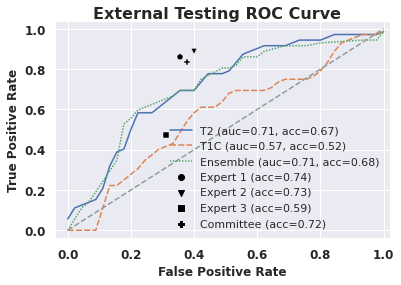

In [52]:
#fig = plot_multiple_precision_recall(train, experts=get_experts_for_names(expert_features, train_set.names))#, comparison_models=get_experts_for_names(comparison_model_features, train_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-train-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(validation, experts=get_experts_for_names(expert_features, validation_set.names))#,  comparison_models=get_experts_for_names(comparison_model_features, validation_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-validation-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(test_1, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-1-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(test_2, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-2-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_roc_curve(train, experts=get_experts_for_names(expert_features, train_set.names))#, comparison_models=get_experts_for_names(comparison_model_features, train_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-train-roc.svg", bbox_inches = "tight")
#fig = plot_multiple_roc_curve(validation, experts=get_experts_for_names(expert_features, validation_set.names))#, comparison_models=get_experts_for_names(comparison_model_features, validation_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-validation-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "committee"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
fig.savefig("figures/combined-test-roc.svg", bbox_inches = "tight")

fig = plot_multiple_roc_curve(external)
fig.savefig("figures/combined-external-roc.svg", bbox_inches = "tight")
#fig = plot_multiple_roc_curve(test_2, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-2-roc.svg", bbox_inches = "tight")

In [43]:
def correct_num_for_modality(dataset, experts=[], comparison_models=[]): 
    results = list()
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
            total = len(labels)
            results.append({ 
                "correct": correct, 
                "total": total, 
                "incorrect": total-correct, 
                "modality": "Expert {}".format(i),
                "acc": correct/total,                
                "wald": adjusted_wald(correct/total, total),
                **calculate_confusion_matrix_stats_predictions(labels, predictions),
            })
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        total = len(labels)
        correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
        results.append({ 
            "correct": correct, 
            "total": total, 
            "incorrect": total-correct, 
            "modality": MODALITY_KEY[modality],
            "acc": correct/total,
            "wald": adjusted_wald(correct/total, total),
            **calculate_confusion_matrix_stats_predictions(labels, predictions),            
        })        
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        predictions = dataset["{}-predictions".format(modality)]
        total = len(labels)
        correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
        results.append({ 
            "correct": correct, 
            "total": total, 
            "incorrect": total-correct, 
            "modality": modality,
            "acc": correct/total,
            "wald": adjusted_wald(correct/total, total),
            **calculate_confusion_matrix_stats_predictions(labels, predictions),            
        })                
    return results

In [45]:
results = correct_num_for_modality(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))

In [95]:
experts = get_experts_for_names(expert_features, test_set.names, experts=["committee"])

In [96]:
kappa_scores = list()
for e in experts: 
    current = list()
    for x in experts: 
        current.append(cohen_kappa_score(e, x))
    kappa_scores.append(current)
kappa_scores

[[1.0, 0.6627565982404693], [0.6627565982404693, 1.0]]

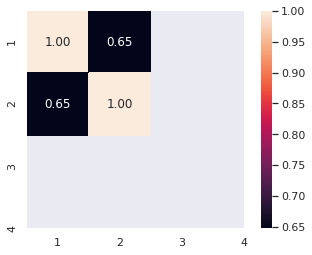

In [48]:
seaborn.heatmap(kappa_scores, annot=True, square=True, fmt=".2f", xticklabels=["1", "2", "3", "4"], yticklabels=["1", "2", "3", "4"])

In [49]:
from itertools import combinations
import numpy as np

In [50]:
unique_kappa = list()
for x, y in combinations(experts, 2): 
    unique_kappa.append(cohen_kappa_score(x, y))
np.average(unique_kappa)

0.6476868327402135

In [51]:
def fleiss_kappa(ratings, n):
    '''
    Computes the Fleiss' kappa measure for assessing the reliability of 
    agreement between a fixed number n of raters when assigning categorical
    ratings to a number of items.
    
    Args:
        ratings: a list of (item, category)-ratings
        n: number of raters
        k: number of categories
    Returns:
        the Fleiss' kappa score
    
    See also:
        http://en.wikipedia.org/wiki/Fleiss'_kappa
    '''
    items = set()
    categories = set()
    n_ij = {}
    
    for i, c in ratings:
        items.add(i)
        categories.add(c)
        n_ij[(i,c)] = n_ij.get((i,c), 0) + 1
    
    N = len(items)
    
    p_j = dict(((c, sum(n_ij.get((i, c), 0) for i in items) / (1.0 * n * N)) for c in categories))
    P_i = dict(((i, (sum(n_ij.get((i, c), 0) ** 2 for c in categories) - n) / (n * (n - 1.0))) for i in items))

    P_bar = sum(P_i.values()) / (1.0 * N)
    P_e_bar = sum(value ** 2 for value in p_j.values())
    
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    
    return kappa

In [52]:
fleiss_kappa_array = list()
for e in list(zip(*experts)): 
    for i in e: 
        fleiss_kappa_array.append((1, i))

In [53]:
fleiss_kappa(fleiss_kappa_array, 4)

-0.33333333333333326

In [54]:
ratings = [(1, 'yes')] * 10 + [(1, 'no')] * 0  + \
[(2, 'yes')] * 8  + [(2, 'no')] * 2  + \
[(3, 'yes')] * 9  + [(3, 'no')] * 1  + \
[(4, 'yes')] * 0  + [(4, 'no')] * 10 + \
[(5, 'yes')] * 7  + [(5, 'no')] * 3
ratings

[(1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'no'),
 (2, 'no'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'no'),
 (5, 'no'),
 (5, 'no')]

In [55]:
x = np.array(experts).T
fleiss_kappa(x)

TypeError: fleiss_kappa() missing 1 required positional argument: 'n'

In [ ]:
ensemble = results.pop()
for r in results: 
    print(r["modality"], fisher_exact([[ensemble["correct"], r["correct"]], [ensemble["incorrect"], r["incorrect"]]]))

In [ ]:
results

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')